In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [7]:
!kaggle datasets download -d paultimothymooney/kermany2018

100% 10.8G/10.8G [01:50<00:00, 31.5MB/s]
100% 10.8G/10.8G [01:50<00:00, 105MB/s] 


In [8]:
import zipfile
zf = "/content/kermany2018.zip"
target_dir = "/content/dataset/retinalOct"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

Data Preprocessing

In [1]:
!pip install opencv-python

In [2]:
!pip install keras

In [3]:
!pip install tensorflow

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
#from google.colab.patches import cv2_imshow

In [2]:
import os
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2DTranspose, Concatenate, Lambda, Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, BatchNormalization, Input, SeparableConv2D, MaxPool2D, UpSampling2D, ZeroPadding2D, Add, Convolution2D, concatenate, GlobalAveragePooling2D, Input
from keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications import VGG16, ResNet101

from keras.optimizers import SGD

In [3]:
!pwd

/Users/sneha/Documents/uWaterloo-VISA/613/research-project


In [4]:
img = cv2.imread('/Users/sneha/Documents/uWaterloo-VISA/613/research-project/retinal-oct-dataset/OCT2017 /train/DME/DME-1072015-1.jpeg',cv2.IMREAD_COLOR)

In [ ]:
cv2.imshow('sample',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [5]:
print(img.shape)

(496, 512, 3)


In [6]:
train_path = '/Users/sneha/Documents/uWaterloo-VISA/613/research-project/retinal-oct-dataset/OCT2017 /train'
test_path = '/Users/sneha/Documents/uWaterloo-VISA/613/research-project/retinal-oct-dataset/OCT2017 /test'
val_path = '/Users/sneha/Documents/uWaterloo-VISA/613/research-project/retinal-oct-dataset/OCT2017 /val'

In [7]:
dic = {'NORMAL':0, 'CNV':1, 'DME':2, 'DRUSEN':3}

In [8]:
# Intensity Normalization
def normalize(img):
    print(img, img.min(),img.max())
    lmin = float(img.min())
    lmax = float(img.max())
    return np.floor(((img-lmin)/(lmax-lmin))*255.0)

In [9]:
def prep_data(dataset_path,thresh):
    X, y = [], []
    for path in os.listdir(dataset_path):
        c = 0
        for i in os.listdir(os.path.join(dataset_path,path)):
            img_path =  os.path.join(dataset_path,path,i)
            c += 1
            if c<=thresh:
                result = [0]*4
                X.append(normalize(cv2.resize(cv2.imread(img_path,cv2.IMREAD_COLOR),(224, 224))))
                result[dic[path]] = 1
                y.append(result)
            else:
                break
    return X,y

In [10]:
X_train, y_train = prep_data(train_path,1000)
X_test, y_test = prep_data(test_path,242)

[[[ 21  21  21]
  [ 38  38  38]
  [ 41  41  41]
  ...
  [ 20  20  20]
  [ 12  12  12]
  [ 23  23  23]]

 [[ 20  20  20]
  [ 48  48  48]
  [ 37  37  37]
  ...
  [ 36  36  36]
  [ 16  16  16]
  [  9   9   9]]

 [[ 46  46  46]
  [ 23  23  23]
  [ 24  24  24]
  ...
  [ 32  32  32]
  [ 26  26  26]
  [ 18  18  18]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]] 0 255
[[[ 8  8  8]
  [ 2  2  2]
  [33 33 33]
  ...
  [ 0  0  0]
  [13 13 13]
  [42 42 42]]

 [[23 23 23]
  [ 2  2  2]
  [18 18 18]
  ...
  [ 0  0  0]
  [13 13 13]
  [34 34 34]]

 [[21 21 21]
  [27 27 27]
  [46 46 46]
  ...
  [14 14 14]
  [ 2  2  2]
  [15 15 15]]

 ...

 [[ 9  9  9]
  [ 6  6  6]
  [10 10 10]
  ...
  [12 12 12]
  [ 0  0  0]
  [ 4  4  4]]

 [[ 4  4  4]
 

[[[19 19 19]
  [ 0  0  0]
  [ 6  6  6]
  ...
  [15 15 15]
  [ 6  6  6]
  [ 4  4  4]]

 [[ 7  7  7]
  [10 10 10]
  [ 9  9  9]
  ...
  [20 20 20]
  [ 5  5  5]
  [ 8  8  8]]

 [[ 5  5  5]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 1  1  1]
  [13 13 13]
  [19 19 19]]

 ...

 [[ 3  3  3]
  [ 3  3  3]
  [ 2  2  2]
  ...
  [10 10 10]
  [ 3  3  3]
  [ 7  7  7]]

 [[ 3  3  3]
  [ 3  3  3]
  [ 1  1  1]
  ...
  [ 2  2  2]
  [ 9  9  9]
  [ 6  6  6]]

 [[ 2  2  2]
  [ 3  3  3]
  [ 4  4  4]
  ...
  [ 1  1  1]
  [ 7  7  7]
  [ 1  1  1]]] 0 241
[[[10 10 10]
  [22 22 22]
  [ 1  1  1]
  ...
  [22 22 22]
  [27 27 27]
  [11 11 11]]

 [[14 14 14]
  [32 32 32]
  [41 41 41]
  ...
  [ 2  2  2]
  [29 29 29]
  [25 25 25]]

 [[17 17 17]
  [11 11 11]
  [ 2  2  2]
  ...
  [32 32 32]
  [ 9  9  9]
  [ 6  6  6]]

 ...

 [[ 3  3  3]
  [ 6  6  6]
  [ 7  7  7]
  ...
  [ 4  4  4]
  [ 0  0  0]
  [ 4  4  4]]

 [[ 0  0  0]
  [ 5  5  5]
  [ 2  2  2]
  ...
  [ 6  6  6]
  [ 5  5  5]
  [ 3  3  3]]

 [[ 1  1  1]
  [ 1  1  1]
  [ 2  2  

[[[ 8  8  8]
  [18 18 18]
  [ 1  1  1]
  ...
  [25 25 25]
  [ 3  3  3]
  [20 20 20]]

 [[31 31 31]
  [17 17 17]
  [ 5  5  5]
  ...
  [13 13 13]
  [32 32 32]
  [ 4  4  4]]

 [[15 15 15]
  [38 38 38]
  [14 14 14]
  ...
  [17 17 17]
  [ 1  1  1]
  [ 4  4  4]]

 ...

 [[ 4  4  4]
  [ 4  4  4]
  [ 5  5  5]
  ...
  [ 0  0  0]
  [ 4  4  4]
  [ 0  0  0]]

 [[ 3  3  3]
  [ 3  3  3]
  [ 6  6  6]
  ...
  [ 0  0  0]
  [ 3  3  3]
  [ 5  5  5]]

 [[ 2  2  2]
  [ 3  3  3]
  [ 0  0  0]
  ...
  [ 1  1  1]
  [ 1  1  1]
  [ 2  2  2]]] 0 254
[[[254 254 254]
  [ 13  13  13]
  [ 30  30  30]
  ...
  [ 33  33  33]
  [ 29  29  29]
  [ 22  22  22]]

 [[254 254 254]
  [ 15  15  15]
  [ 31  31  31]
  ...
  [ 24  24  24]
  [ 26  26  26]
  [ 25  25  25]]

 [[254 254 254]
  [  1   1   1]
  [  3   3   3]
  ...
  [  5   5   5]
  [ 23  23  23]
  [ 22  22  22]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 22  22  22]
  [ 20  20  20]
  [ 15  15  15]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 26  26  26]
  [ 18  18  18]
  [ 15  15  15]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 18  18  18]
  [ 11  11  11]
  [ 10  10  10]]

 ...

 [[  8   8   8]
  [ 12  12  12]
  [  8   8   8]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[  5   5   5]
  [ 12  12  12]
  [ 10  10  10]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[  8   8   8]
  [ 10  10  10]
  [  8   8   8]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]] 0 255
[[[ 6  6  6]
  [23 23 23]
  [33 33 33]
  ...
  [ 3  3  3]
  [12 12 12]
  [ 1  1  1]]

 [[17 17 17]
  [ 1  1  1]
  [ 1  1  1]
  ...
  [ 6  6  6]
  [16 16 16]
  [ 2  2  2]]

 [[ 9  9  9]
  [ 2  2  2]
  [ 1  1  1]
  ...
  [25 25 25]
  [ 3  3  3]
  [ 3  3  3]]

 ...

 [[13 13 13]
  [12 12 12]
  [ 2  2  2]
  ...
  [ 8  8  8]
  [ 5  5  5]
  [ 0  0  0]]

 [[ 1  1  1]
 

[[[ 1  1  1]
  [ 1  1  1]
  [ 9  9  9]
  ...
  [13 13 13]
  [ 4  4  4]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [10 10 10]
  ...
  [11 11 11]
  [ 5  5  5]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 8  8  8]
  [ 9  9  9]
  ...
  [ 3  3  3]
  [ 6  6  6]
  [ 5  5  5]]

 ...

 [[ 0  0  0]
  [ 6  6  6]
  [ 4  4  4]
  ...
  [ 3  3  3]
  [ 0  0  0]
  [ 7  7  7]]

 [[ 0  0  0]
  [ 3  3  3]
  [ 5  5  5]
  ...
  [ 1  1  1]
  [ 8  8  8]
  [ 6  6  6]]

 [[ 1  1  1]
  [ 1  1  1]
  [ 2  2  2]
  ...
  [ 5  5  5]
  [ 7  7  7]
  [ 5  5  5]]] 0 255
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[ 10  10  10]
  [ 20  20  20]
  [ 11  11  11]
  ...
  [ 18  18  18]
  [  9   9   9]
  [ 93  93  93]]

 [[ 26  26  26]
  [ 13  13  13]
  [ 11  11  11]
  

[[[10 10 10]
  [21 21 21]
  [ 8  8  8]
  ...
  [12 12 12]
  [12 12 12]
  [ 0  0  0]]

 [[13 13 13]
  [ 6  6  6]
  [ 7  7  7]
  ...
  [ 6  6  6]
  [17 17 17]
  [ 0  0  0]]

 [[17 17 17]
  [ 6  6  6]
  [28 28 28]
  ...
  [ 2  2  2]
  [13 13 13]
  [ 0  0  0]]

 ...

 [[ 3  3  3]
  [ 3  3  3]
  [ 1  1  1]
  ...
  [ 3  3  3]
  [ 2  2  2]
  [ 0  0  0]]

 [[17 17 17]
  [22 22 22]
  [ 2  2  2]
  ...
  [ 3  3  3]
  [ 4  4  4]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 5  5  5]
  [13 13 13]
  ...
  [ 3  3  3]
  [ 8  8  8]
  [ 0  0  0]]] 0 241
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[ 99  99  99]
  [ 19  19  19]
  [ 16  16  16]
  ...
  [ 14  14  14]
  [  6   6   6]
  [  1   1   1]]

 [[ 97  97  97]
  [ 10  10  10]
  [ 13  13  13]
  

[[[ 6  6  6]
  [ 4  4  4]
  [ 5  5  5]
  ...
  [ 1  1  1]
  [11 11 11]
  [21 21 21]]

 [[ 2  2  2]
  [25 25 25]
  [ 5  5  5]
  ...
  [ 7  7  7]
  [ 4  4  4]
  [ 2  2  2]]

 [[34 34 34]
  [43 43 43]
  [ 2  2  2]
  ...
  [ 0  0  0]
  [30 30 30]
  [11 11 11]]

 ...

 [[18 18 18]
  [ 2  2  2]
  [ 0  0  0]
  ...
  [ 1  1  1]
  [ 1  1  1]
  [ 3  3  3]]

 [[16 16 16]
  [ 4  4  4]
  [15 15 15]
  ...
  [ 2  2  2]
  [ 1  1  1]
  [ 5  5  5]]

 [[ 9  9  9]
  [ 0  0  0]
  [15 15 15]
  ...
  [ 5  5  5]
  [ 5  5  5]
  [ 2  2  2]]] 0 254
[[[ 0  0  0]
  [ 2  2  2]
  [ 3  3  3]
  ...
  [ 8  8  8]
  [ 2  2  2]
  [ 1  1  1]]

 [[ 0  0  0]
  [ 3  3  3]
  [ 9  9  9]
  ...
  [ 5  5  5]
  [ 0  0  0]
  [ 1  1  1]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 3  3  3]
  [ 2  2  2]
  [ 2  2  2]]

 ...

 [[ 0  0  0]
  [ 9  9  9]
  [13 13 13]
  ...
  [21 21 21]
  [21 21 21]
  [ 1  1  1]]

 [[ 1  1  1]
  [15 15 15]
  [31 31 31]
  ...
  [17 17 17]
  [16 16 16]
  [10 10 10]]

 [[ 0  0  0]
  [10 10 10]
  [23 23 2

[[[ 1  1  1]
  [10 10 10]
  [ 3  3  3]
  ...
  [ 1  1  1]
  [24 24 24]
  [ 2  2  2]]

 [[ 1  1  1]
  [33 33 33]
  [24 24 24]
  ...
  [10 10 10]
  [ 5  5  5]
  [16 16 16]]

 [[ 2  2  2]
  [27 27 27]
  [41 41 41]
  ...
  [20 20 20]
  [12 12 12]
  [13 13 13]]

 ...

 [[ 4  4  4]
  [ 5  5  5]
  [ 9  9  9]
  ...
  [ 0  0  0]
  [10 10 10]
  [ 1  1  1]]

 [[ 7  7  7]
  [ 7  7  7]
  [ 0  0  0]
  ...
  [ 4  4  4]
  [ 4  4  4]
  [ 0  0  0]]

 [[ 4  4  4]
  [ 2  2  2]
  [ 2  2  2]
  ...
  [ 5  5  5]
  [ 2  2  2]
  [ 2  2  2]]] 0 254
[[[24 24 24]
  [13 13 13]
  [51 51 51]
  ...
  [ 2  2  2]
  [19 19 19]
  [ 5  5  5]]

 [[41 41 41]
  [23 23 23]
  [46 46 46]
  ...
  [ 0  0  0]
  [14 14 14]
  [18 18 18]]

 [[36 36 36]
  [12 12 12]
  [46 46 46]
  ...
  [ 4  4  4]
  [12 12 12]
  [19 19 19]]

 ...

 [[ 5  5  5]
  [11 11 11]
  [ 2  2  2]
  ...
  [19 19 19]
  [ 1  1  1]
  [11 11 11]]

 [[ 5  5  5]
  [20 20 20]
  [ 2  2  2]
  ...
  [14 14 14]
  [11 11 11]
  [ 9  9  9]]

 [[ 2  2  2]
  [ 6  6  6]
  [ 8  8  

[[[128 128 128]
  [ 81  81  81]
  [ 46  46  46]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[124 124 124]
  [ 14  14  14]
  [ 31  31  31]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[143 143 143]
  [ 39  39  39]
  [ 51  51  51]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[ 91  91  91]
  [  6   6   6]
  [ 23  23  23]
  ...
  [ 14  14  14]
  [ 11  11  11]
  [ 11  11  11]]

 [[102 102 102]
  [  8   8   8]
  [ 19  19  19]
  ...
  [  0   0   0]
  [  2   2   2]
  [ 16  16  16]]

 [[254 254 254]
  [254 254 254]
  [220 220 220]
  ...
  [ 19  19  19]
  [ 32  32  32]
  [  1   1   1]]] 0 255
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[254 254 254]
  [255 255 255]
  [253 253 253]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[244 244 244]
  [246 246 246]
  [242 242 242]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[  7   7   7]
  [  5   5   5]
  [ 10  10  10

[[[38 38 38]
  [20 20 20]
  [ 7  7  7]
  ...
  [21 21 21]
  [ 8  8  8]
  [23 23 23]]

 [[12 12 12]
  [36 36 36]
  [ 5  5  5]
  ...
  [ 4  4  4]
  [12 12 12]
  [19 19 19]]

 [[15 15 15]
  [20 20 20]
  [15 15 15]
  ...
  [ 0  0  0]
  [10 10 10]
  [ 6  6  6]]

 ...

 [[ 2  2  2]
  [ 7  7  7]
  [12 12 12]
  ...
  [ 8  8  8]
  [ 9  9  9]
  [ 9  9  9]]

 [[ 4  4  4]
  [ 5  5  5]
  [ 2  2  2]
  ...
  [ 5  5  5]
  [ 6  6  6]
  [ 6  6  6]]

 [[ 7  7  7]
  [ 3  3  3]
  [ 2  2  2]
  ...
  [ 0  0  0]
  [ 5  5  5]
  [ 7  7  7]]] 0 255
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 13  13  13]
  [  5   5   5]
  [ 17  17  17]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 25  25  25]
  [ 28  28  28]
  [ 19  19  19]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 23  23  23]
  [ 18  18  18]
  [ 24  24  24]]

 ...

 [[ 98  98  98]
  [ 14  14  14]
  [  3   3   3]
  ...
  [  7   7   7]
  [  5   5   5]
  [  4   4   4]]

 [[ 94  94  94]
  [  9   9   9]
  [  9   9   9]
  

[[[37 37 37]
  [41 41 41]
  [33 33 33]
  ...
  [16 16 16]
  [ 9  9  9]
  [ 3  3  3]]

 [[32 32 32]
  [40 40 40]
  [39 39 39]
  ...
  [19 19 19]
  [17 17 17]
  [ 1  1  1]]

 [[22 22 22]
  [34 34 34]
  [30 30 30]
  ...
  [19 19 19]
  [14 14 14]
  [ 3  3  3]]

 ...

 [[ 1  1  1]
  [ 4  4  4]
  [ 0  0  0]
  ...
  [ 3  3  3]
  [ 4  4  4]
  [ 1  1  1]]

 [[ 2  2  2]
  [ 5  5  5]
  [ 1  1  1]
  ...
  [ 3  3  3]
  [ 1  1  1]
  [ 1  1  1]]

 [[ 1  1  1]
  [ 1  1  1]
  [ 0  0  0]
  ...
  [ 3  3  3]
  [ 0  0  0]
  [ 1  1  1]]] 0 255
[[[ 37  37  37]
  [ 71  71  71]
  [ 50  50  50]
  ...
  [ 27  27  27]
  [ 19  19  19]
  [122 122 122]]

 [[  4   4   4]
  [ 43  43  43]
  [ 54  54  54]
  ...
  [ 72  72  72]
  [ 18  18  18]
  [100 100 100]]

 [[  5   5   5]
  [ 28  28  28]
  [ 10  10  10]
  ...
  [ 39  39  39]
  [ 32  32  32]
  [ 91  91  91]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  

[[[ 4  4  4]
  [ 3  3  3]
  [10 10 10]
  ...
  [26 26 26]
  [22 22 22]
  [ 9  9  9]]

 [[18 18 18]
  [ 3  3  3]
  [11 11 11]
  ...
  [25 25 25]
  [23 23 23]
  [ 8  8  8]]

 [[11 11 11]
  [45 45 45]
  [28 28 28]
  ...
  [31 31 31]
  [32 32 32]
  [15 15 15]]

 ...

 [[ 6  6  6]
  [10 10 10]
  [11 11 11]
  ...
  [ 2  2  2]
  [ 3  3  3]
  [ 1  1  1]]

 [[ 2  2  2]
  [ 5  5  5]
  [ 6  6  6]
  ...
  [ 1  1  1]
  [ 5  5  5]
  [ 1  1  1]]

 [[ 2  2  2]
  [ 6  6  6]
  [ 5  5  5]
  ...
  [ 3  3  3]
  [ 2  2  2]
  [ 1  1  1]]] 0 251
[[[254 254 254]
  [249 249 249]
  [  4   4   4]
  ...
  [ 42  42  42]
  [ 12  12  12]
  [ 24  24  24]]

 [[254 254 254]
  [243 243 243]
  [  7   7   7]
  ...
  [ 22  22  22]
  [ 22  22  22]
  [ 21  21  21]]

 [[254 254 254]
  [247 247 247]
  [ 15  15  15]
  ...
  [ 39  39  39]
  [ 28  28  28]
  [ 21  21  21]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  

[[[ 5  5  5]
  [25 25 25]
  [20 20 20]
  ...
  [ 4  4  4]
  [22 22 22]
  [ 1  1  1]]

 [[14 14 14]
  [ 1  1  1]
  [22 22 22]
  ...
  [38 38 38]
  [ 2  2  2]
  [ 4  4  4]]

 [[10 10 10]
  [23 23 23]
  [30 30 30]
  ...
  [17 17 17]
  [12 12 12]
  [35 35 35]]

 ...

 [[ 1  1  1]
  [ 7  7  7]
  [ 2  2  2]
  ...
  [ 2  2  2]
  [ 4  4  4]
  [ 7  7  7]]

 [[ 7  7  7]
  [ 8  8  8]
  [ 3  3  3]
  ...
  [ 6  6  6]
  [ 7  7  7]
  [ 3  3  3]]

 [[ 4  4  4]
  [ 1  1  1]
  [ 5  5  5]
  ...
  [ 8  8  8]
  [ 8  8  8]
  [ 0  0  0]]] 0 254
[[[254 254 254]
  [ 42  42  42]
  [ 12  12  12]
  ...
  [253 253 253]
  [248 248 248]
  [251 251 251]]

 [[254 254 254]
  [ 31  31  31]
  [ 27  27  27]
  ...
  [253 253 253]
  [255 255 255]
  [253 253 253]]

 [[255 255 255]
  [ 21  21  21]
  [ 25  25  25]
  ...
  [ 18  18  18]
  [245 245 245]
  [246 246 246]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [  3   3   3]
  [ 13  13  13]
  [  7   7   7]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[  1   1   1]
  [ 29  29  29]
  [ 27  27  27]
  ...
  [ 31  31  31]
  [ 29  29  29]
  [  6   6   6]]

 [[  0   0   0]
  [ 22  22  22]
  [ 33  33  33]
  ...
  [ 24  24  24]
  [  0   0   0]
  [  6   6   6]]

 [[ 26  26  26]
  [ 23  23  23]
  [ 31  31  31]
  ...
  [ 13  13  13]
  [  4   4   4]
  [ 18  18  18]]] 0 255
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[ 16  16  16]
  [ 20  20  20]
  [  8   8   8

[[[ 4  4  4]
  [28 28 28]
  [ 4  4  4]
  ...
  [20 20 20]
  [ 9  9  9]
  [ 0  0  0]]

 [[22 22 22]
  [ 2  2  2]
  [28 28 28]
  ...
  [15 15 15]
  [22 22 22]
  [ 2  2  2]]

 [[19 19 19]
  [18 18 18]
  [25 25 25]
  ...
  [ 1  1  1]
  [16 16 16]
  [ 3  3  3]]

 ...

 [[ 8  8  8]
  [10 10 10]
  [ 4  4  4]
  ...
  [ 2  2  2]
  [ 4  4  4]
  [ 0  0  0]]

 [[ 5  5  5]
  [10 10 10]
  [ 0  0  0]
  ...
  [ 8  8  8]
  [ 2  2  2]
  [ 2  2  2]]

 [[ 2  2  2]
  [ 8  8  8]
  [ 9  9  9]
  ...
  [ 1  1  1]
  [ 0  0  0]
  [ 0  0  0]]] 0 254
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[104 104 104]
  [ 27  27  27]
  [ 19  19  19]
  ...
  [ 15  15  15]
  [ 21  21  21]
  [  9   9   9]]

 [[103 103 103]
  [ 18  18  18]
  [ 22  22  22]
  

[[[ 16  16  16]
  [ 33  33  33]
  [ 43  43  43]
  ...
  [ 33  33  33]
  [ 11  11  11]
  [112 112 112]]

 [[ 32  32  32]
  [  1   1   1]
  [ 38  38  38]
  ...
  [ 12  12  12]
  [ 24  24  24]
  [108 108 108]]

 [[ 15  15  15]
  [ 23  23  23]
  [  7   7   7]
  ...
  [  9   9   9]
  [  8   8   8]
  [100 100 100]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]] 0 255
[[[254 254 254]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [254 254 254]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[  2   2   2]
  [  0   0   0]
  [  9   9   9

[[[ 37  37  37]
  [ 30  30  30]
  [ 33  33  33]
  ...
  [ 22  22  22]
  [ 21  21  21]
  [253 253 253]]

 [[ 32  32  32]
  [ 22  22  22]
  [ 31  31  31]
  ...
  [ 18  18  18]
  [ 10  10  10]
  [253 253 253]]

 [[ 23  23  23]
  [ 22  22  22]
  [ 11  11  11]
  ...
  [ 17  17  17]
  [  8   8   8]
  [252 252 252]]

 ...

 [[246 246 246]
  [246 246 246]
  [246 246 246]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]] 0 255
[[[ 2  2  2]
  [ 2  2  2]
  [ 5  5  5]
  ...
  [ 8  8  8]
  [ 9  9  9]
  [ 3  3  3]]

 [[ 2  2  2]
  [13 13 13]
  [ 2  2  2]
  ...
  [ 9  9  9]
  [13 13 13]
  [ 4  4  4]]

 [[ 6  6  6]
  [ 6  6  6]
  [ 4  4  4]
  ...
  [11 11 11]
  [13 13 13]
  [ 3  3  3]]

 ...

 [[ 4  4  4]
  [ 1  1  1]
  [ 6  6  6]
  ...
  [ 3  3  3]
  [ 3  3  3]
  [ 1  1  1]]

 [[ 4  4  4]
 

[[[32 32 32]
  [26 26 26]
  [45 45 45]
  ...
  [44 44 44]
  [19 19 19]
  [ 2  2  2]]

 [[32 32 32]
  [36 36 36]
  [80 80 80]
  ...
  [54 54 54]
  [10 10 10]
  [26 26 26]]

 [[13 13 13]
  [ 2  2  2]
  [32 32 32]
  ...
  [52 52 52]
  [24 24 24]
  [10 10 10]]

 ...

 [[ 1  1  1]
  [11 11 11]
  [ 2  2  2]
  ...
  [ 2  2  2]
  [ 6  6  6]
  [ 4  4  4]]

 [[ 4  4  4]
  [ 3  3  3]
  [ 7  7  7]
  ...
  [ 4  4  4]
  [ 4  4  4]
  [11 11 11]]

 [[14 14 14]
  [ 1  1  1]
  [ 2  2  2]
  ...
  [ 3  3  3]
  [ 7  7  7]
  [ 0  0  0]]] 0 253
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 25  25  25]
  [ 17  17  17]
  [  2   2   2]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  

[[[ 0  0  0]
  [14 14 14]
  [ 3  3  3]
  ...
  [15 15 15]
  [ 9  9  9]
  [15 15 15]]

 [[ 1  1  1]
  [25 25 25]
  [ 7  7  7]
  ...
  [13 13 13]
  [ 7  7  7]
  [17 17 17]]

 [[ 9  9  9]
  [16 16 16]
  [33 33 33]
  ...
  [15 15 15]
  [12 12 12]
  [ 3  3  3]]

 ...

 [[11 11 11]
  [ 2  2  2]
  [14 14 14]
  ...
  [ 2  2  2]
  [ 0  0  0]
  [ 1  1  1]]

 [[14 14 14]
  [12 12 12]
  [12 12 12]
  ...
  [ 0  0  0]
  [ 5  5  5]
  [ 2  2  2]]

 [[ 1  1  1]
  [ 4  4  4]
  [ 5  5  5]
  ...
  [ 1  1  1]
  [ 4  4  4]
  [ 2  2  2]]] 0 252
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[ 24  24  24]
  [ 25  25  25]
  [ 20  20  20]
  ...
  [ 13  13  13]
  [ 22  22  22]
  [ 91  91  91]]

 [[ 21  21  21]
  [ 24  24  24]
  [  9   9   9]
  

[[[ 9  9  9]
  [ 2  2  2]
  [44 44 44]
  ...
  [18 18 18]
  [31 31 31]
  [23 23 23]]

 [[41 41 41]
  [45 45 45]
  [52 52 52]
  ...
  [47 47 47]
  [36 36 36]
  [18 18 18]]

 [[67 67 67]
  [29 29 29]
  [38 38 38]
  ...
  [ 0  0  0]
  [11 11 11]
  [27 27 27]]

 ...

 [[ 4  4  4]
  [ 0  0  0]
  [ 3  3  3]
  ...
  [ 7  7  7]
  [ 4  4  4]
  [ 4  4  4]]

 [[ 4  4  4]
  [ 4  4  4]
  [ 3  3  3]
  ...
  [ 7  7  7]
  [ 0  0  0]
  [ 4  4  4]]

 [[ 2  2  2]
  [ 6  6  6]
  [ 6  6  6]
  ...
  [ 1  1  1]
  [ 8  8  8]
  [ 3  3  3]]] 0 250
[[[255 255 255]
  [255 255 255]
  [196 196 196]
  ...
  [ 27  27  27]
  [ 23  23  23]
  [  7   7   7]]

 [[254 254 254]
  [255 255 255]
  [198 198 198]
  ...
  [ 31  31  31]
  [ 24  24  24]
  [ 26  26  26]]

 [[255 255 255]
  [254 254 254]
  [195 195 195]
  ...
  [ 33  33  33]
  [ 34  34  34]
  [ 26  26  26]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[254 254 254]
  [ 24  24  24]
  [ 28  28  28]
  ...
  [ 14  14  14]
  [  5   5   5]
  [ 10  10  10]]

 [[254 254 254]
  [ 27  27  27]
  [ 27  27  27]
  ...
  [ 16  16  16]
  [  3   3   3]
  [ 18  18  18]]

 [[255 255 255]
  [ 28  28  28]
  [ 20  20  20]
  ...
  [ 13  13  13]
  [ 16  16  16]
  [  6   6   6]]] 0 255
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[ 10  10  10]
  [  2   2   2]
  [  4   4   4

[[[252 252 252]
  [ 24  24  24]
  [ 38  38  38]
  ...
  [249 249 249]
  [254 254 254]
  [254 254 254]]

 [[254 254 254]
  [ 39  39  39]
  [ 39  39  39]
  ...
  [250 250 250]
  [242 242 242]
  [255 255 255]]

 [[255 255 255]
  [ 38  38  38]
  [ 39  39  39]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 ...

 [[253 253 253]
  [  4   4   4]
  [ 14  14  14]
  ...
  [  4   4   4]
  [  5   5   5]
  [  4   4   4]]

 [[252 252 252]
  [ 16  16  16]
  [  2   2   2]
  ...
  [  9   9   9]
  [  5   5   5]
  [  7   7   7]]

 [[252 252 252]
  [254 254 254]
  [253 253 253]
  ...
  [  5   5   5]
  [  5   5   5]
  [  5   5   5]]] 0 255
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[253 253 253]
  [ 41  41  41]
  [ 17  17  17

[[[ 0  0  0]
  [ 6  6  6]
  [15 15 15]
  ...
  [ 1  1  1]
  [ 7  7  7]
  [ 2  2  2]]

 [[ 1  1  1]
  [ 2  2  2]
  [13 13 13]
  ...
  [16 16 16]
  [10 10 10]
  [ 3  3  3]]

 [[11 11 11]
  [15 15 15]
  [19 19 19]
  ...
  [17 17 17]
  [ 3  3  3]
  [11 11 11]]

 ...

 [[ 2  2  2]
  [ 2  2  2]
  [ 4  4  4]
  ...
  [ 5  5  5]
  [ 2  2  2]
  [ 4  4  4]]

 [[ 0  0  0]
  [ 8  8  8]
  [ 9  9  9]
  ...
  [ 3  3  3]
  [ 4  4  4]
  [ 3  3  3]]

 [[ 1  1  1]
  [ 3  3  3]
  [ 8  8  8]
  ...
  [ 5  5  5]
  [ 2  2  2]
  [ 1  1  1]]] 0 255
[[[ 1  1  1]
  [ 1  1  1]
  [14 14 14]
  ...
  [ 4  4  4]
  [ 5  5  5]
  [15 15 15]]

 [[ 1  1  1]
  [ 1  1  1]
  [ 3  3  3]
  ...
  [ 1  1  1]
  [ 2  2  2]
  [ 7  7  7]]

 [[ 1  1  1]
  [ 4  4  4]
  [25 25 25]
  ...
  [35 35 35]
  [15 15 15]
  [20 20 20]]

 ...

 [[ 0  0  0]
  [ 3  3  3]
  [11 11 11]
  ...
  [ 8  8  8]
  [ 0  0  0]
  [ 1  1  1]]

 [[ 0  0  0]
  [10 10 10]
  [ 3  3  3]
  ...
  [ 4  4  4]
  [ 0  0  0]
  [ 3  3  3]]

 [[ 0  0  0]
  [ 3  3  3]
  [11 11 1

[[[34 34 34]
  [28 28 28]
  [10 10 10]
  ...
  [11 11 11]
  [13 13 13]
  [13 13 13]]

 [[27 27 27]
  [31 31 31]
  [34 34 34]
  ...
  [ 6  6  6]
  [22 22 22]
  [12 12 12]]

 [[ 3  3  3]
  [11 11 11]
  [12 12 12]
  ...
  [ 0  0  0]
  [ 5  5  5]
  [ 4  4  4]]

 ...

 [[ 1  1  1]
  [ 6  6  6]
  [ 6  6  6]
  ...
  [ 4  4  4]
  [ 3  3  3]
  [ 0  0  0]]

 [[ 1  1  1]
  [ 1  1  1]
  [ 4  4  4]
  ...
  [ 3  3  3]
  [ 7  7  7]
  [ 1  1  1]]

 [[ 2  2  2]
  [ 2  2  2]
  [ 5  5  5]
  ...
  [ 4  4  4]
  [ 6  6  6]
  [ 1  1  1]]] 0 254
[[[17 17 17]
  [43 43 43]
  [50 50 50]
  ...
  [27 27 27]
  [ 8  8  8]
  [16 16 16]]

 [[42 42 42]
  [15 15 15]
  [58 58 58]
  ...
  [ 1  1  1]
  [40 40 40]
  [ 0  0  0]]

 [[29 29 29]
  [ 2  2  2]
  [29 29 29]
  ...
  [24 24 24]
  [ 3  3  3]
  [10 10 10]]

 ...

 [[ 4  4  4]
  [ 0  0  0]
  [13 13 13]
  ...
  [10 10 10]
  [ 3  3  3]
  [ 6  6  6]]

 [[ 0  0  0]
  [ 4  4  4]
  [ 3  3  3]
  ...
  [ 1  1  1]
  [ 0  0  0]
  [ 8  8  8]]

 [[ 1  1  1]
  [ 4  4  4]
  [ 3  3  

[[[ 34  34  34]
  [ 21  21  21]
  [ 10  10  10]
  ...
  [ 17  17  17]
  [ 19  19  19]
  [252 252 252]]

 [[ 37  37  37]
  [ 28  28  28]
  [ 13  13  13]
  ...
  [ 27  27  27]
  [ 18  18  18]
  [253 253 253]]

 [[ 16  16  16]
  [ 19  19  19]
  [  0   0   0]
  ...
  [ 21  21  21]
  [ 27  27  27]
  [253 253 253]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[252 252 252]
  [253 253 253]
  [254 254 254]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[253 253 253]
  [254 254 254]
  [254 254 254]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]] 0 255
[[[ 32  32  32]
  [ 36  36  36]
  [ 17  17  17]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[ 38  38  38]
  [ 45  45  45]
  [ 34  34  34]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[ 46  46  46]
  [ 34  34  34]
  [ 34  34  34]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[ 14  14  14]
  [ 14  14  14]
  [ 14  14  14

[[[ 23  23  23]
  [ 22  22  22]
  [ 22  22  22]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[ 26  26  26]
  [ 24  24  24]
  [ 22  22  22]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[ 23  23  23]
  [ 22  22  22]
  [ 21  21  21]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [  4   4   4]
  [  4   4   4]
  [  3   3   3]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [  5   5   5]
  [  5   5   5]
  [  2   2   2]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [  4   4   4]
  [  6   6   6]
  [  3   3   3]]] 0 255
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[108 108 108]
  [ 24  24  24]
  [ 25  25  25

[[[101 101 101]
  [ 42  42  42]
  [ 46  46  46]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[ 99  99  99]
  [ 47  47  47]
  [ 38  38  38]
  ...
  [255 255 255]
  [253 253 253]
  [254 254 254]]

 [[101 101 101]
  [ 37  37  37]
  [ 29  29  29]
  ...
  [245 245 245]
  [243 243 243]
  [243 243 243]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 10  10  10]
  [  6   6   6]
  [ 10  10  10]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [  8   8   8]
  [  2   2   2]
  [  1   1   1]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 12  12  12]
  [  9   9   9]
  [  3   3   3]]] 0 255
[[[ 18  18  18]
  [ 42  42  42]
  [ 51  51  51]
  ...
  [ 37  37  37]
  [ 24  24  24]
  [ 29  29  29]]

 [[  0   0   0]
  [  7   7   7]
  [ 35  35  35]
  ...
  [ 27  27  27]
  [ 19  19  19]
  [ 22  22  22]]

 [[ 27  27  27]
  [ 31  31  31]
  [ 26  26  26]
  ...
  [ 22  22  22]
  [ 36  36  36]
  [ 17  17  17]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255

[[[19 19 19]
  [ 4  4  4]
  [ 9  9  9]
  ...
  [11 11 11]
  [ 3  3  3]
  [ 1  1  1]]

 [[19 19 19]
  [ 1  1  1]
  [11 11 11]
  ...
  [ 0  0  0]
  [11 11 11]
  [20 20 20]]

 [[ 2  2  2]
  [39 39 39]
  [ 6  6  6]
  ...
  [ 0  0  0]
  [16 16 16]
  [ 7  7  7]]

 ...

 [[ 7  7  7]
  [ 4  4  4]
  [ 5  5  5]
  ...
  [ 4  4  4]
  [ 4  4  4]
  [ 1  1  1]]

 [[ 2  2  2]
  [ 3  3  3]
  [12 12 12]
  ...
  [ 5  5  5]
  [ 3  3  3]
  [ 1  1  1]]

 [[12 12 12]
  [ 3  3  3]
  [13 13 13]
  ...
  [ 0  0  0]
  [ 2  2  2]
  [ 0  0  0]]] 0 254
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 11  11  11]
  [ 13  13  13]
  [  2   2   2]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  

[[[ 0  0  0]
  [ 0  0  0]
  [ 1  1  1]
  ...
  [ 6  6  6]
  [10 10 10]
  [ 6  6  6]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 1  1  1]
  ...
  [13 13 13]
  [ 4  4  4]
  [ 5  5  5]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 1  1  1]
  ...
  [15 15 15]
  [ 2  2  2]
  [ 6  6  6]]

 ...

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 5  5  5]
  [ 7  7  7]
  [ 5  5  5]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 2  2  2]
  [ 2  2  2]
  [ 3  3  3]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 3  3  3]
  [ 1  1  1]
  [ 1  1  1]]] 0 254
[[[ 0  0  0]
  [ 4  4  4]
  [20 20 20]
  ...
  [42 42 42]
  [ 1  1  1]
  [ 9  9  9]]

 [[22 22 22]
  [ 5  5  5]
  [ 7  7  7]
  ...
  [19 19 19]
  [34 34 34]
  [ 7  7  7]]

 [[13 13 13]
  [51 51 51]
  [63 63 63]
  ...
  [10 10 10]
  [17 17 17]
  [17 17 17]]

 ...

 [[ 9  9  9]
  [ 3  3  3]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 1  1  1]
  [ 4  4  4]]

 [[ 1  1  1]
  [ 1  1  1]
  [ 5  5  5]
  ...
  [ 8  8  8]
  [ 0  0  0]
  [ 4  4  4]]

 [[ 3  3  3]
  [ 2  2  2]
  [12 12 1

[[[ 3  3  3]
  [ 7  7  7]
  [ 5  5  5]
  ...
  [ 5  5  5]
  [ 4  4  4]
  [10 10 10]]

 [[ 1  1  1]
  [ 2  2  2]
  [14 14 14]
  ...
  [ 9  9  9]
  [17 17 17]
  [22 22 22]]

 [[26 26 26]
  [ 4  4  4]
  [ 2  2  2]
  ...
  [13 13 13]
  [33 33 33]
  [20 20 20]]

 ...

 [[ 4  4  4]
  [ 0  0  0]
  [29 29 29]
  ...
  [ 2  2  2]
  [16 16 16]
  [ 6  6  6]]

 [[22 22 22]
  [ 1  1  1]
  [21 21 21]
  ...
  [ 6  6  6]
  [ 4  4  4]
  [13 13 13]]

 [[ 6  6  6]
  [ 3  3  3]
  [ 5  5  5]
  ...
  [ 2  2  2]
  [ 6  6  6]
  [ 0  0  0]]] 0 254
[[[ 33  33  33]
  [ 29  29  29]
  [ 23  23  23]
  ...
  [253 253 253]
  [254 254 254]
  [249 249 249]]

 [[ 29  29  29]
  [ 21  21  21]
  [ 28  28  28]
  ...
  [255 255 255]
  [253 253 253]
  [248 248 248]]

 [[ 31  31  31]
  [ 10  10  10]
  [ 20  20  20]
  ...
  [249 249 249]
  [250 250 250]
  [249 249 249]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [  4   4   4]
  [  5   5   5]
  [ 90  90  90]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  

[[[ 28  28  28]
  [ 28  28  28]
  [ 38  38  38]
  ...
  [254 254 254]
  [253 253 253]
  [250 250 250]]

 [[ 24  24  24]
  [ 38  38  38]
  [ 36  36  36]
  ...
  [252 252 252]
  [254 254 254]
  [244 244 244]]

 [[ 46  46  46]
  [ 70  70  70]
  [ 24  24  24]
  ...
  [ 26  26  26]
  [  6   6   6]
  [ 91  91  91]]

 ...

 [[  1   1   1]
  [  0   0   0]
  [  2   2   2]
  ...
  [  9   9   9]
  [ 15  15  15]
  [ 90  90  90]]

 [[252 252 252]
  [252 252 252]
  [253 253 253]
  ...
  [  5   5   5]
  [  7   7   7]
  [ 95  95  95]]

 [[253 253 253]
  [253 253 253]
  [253 253 253]
  ...
  [  3   3   3]
  [  6   6   6]
  [ 93  93  93]]] 0 255
[[[ 21  21  21]
  [ 49  49  49]
  [ 23  23  23]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[ 27  27  27]
  [  7   7   7]
  [ 43  43  43]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[ 19  19  19]
  [  1   1   1]
  [ 28  28  28]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[253 253 253]
  [254 254 254]
  [246 246 246

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [  9   9   9]
  [ 18  18  18]
  [  5   5   5]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 12  12  12]
  [ 16  16  16]
  [ 16  16  16]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 16  16  16]
  [ 15  15  15]
  [ 20  20  20]]

 ...

 [[ 93  93  93]
  [  7   7   7]
  [  9   9   9]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[ 91  91  91]
  [  0   0   0]
  [ 13  13  13]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[ 92  92  92]
  [  6   6   6]
  [  8   8   8]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]] 0 255
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 26  26  26]
  [  7   7   7]
  [ 20  20  20]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 20  20  20]
  [ 30  30  30]
  [ 26  26  26]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [  2   2   2]
  [  9   9   9]
  [ 29  29  29]]

 ...

 [[ 92  92  92]
  [  9   9   9]
  [ 19  19  19

[[[ 2  2  2]
  [18 18 18]
  [10 10 10]
  ...
  [18 18 18]
  [14 14 14]
  [25 25 25]]

 [[ 7  7  7]
  [13 13 13]
  [17 17 17]
  ...
  [ 2  2  2]
  [ 3  3  3]
  [17 17 17]]

 [[ 3  3  3]
  [25 25 25]
  [ 9  9  9]
  ...
  [ 9  9  9]
  [11 11 11]
  [16 16 16]]

 ...

 [[ 2  2  2]
  [ 4  4  4]
  [ 8  8  8]
  ...
  [ 1  1  1]
  [12 12 12]
  [ 2  2  2]]

 [[ 1  1  1]
  [ 9  9  9]
  [ 4  4  4]
  ...
  [ 7  7  7]
  [12 12 12]
  [ 0  0  0]]

 [[ 1  1  1]
  [ 7  7  7]
  [ 8  8  8]
  ...
  [ 3  3  3]
  [ 9  9  9]
  [ 1  1  1]]] 0 254
[[[122 122 122]
  [ 39  39  39]
  [ 40  40  40]
  ...
  [ 37  37  37]
  [  7   7   7]
  [ 16  16  16]]

 [[121 121 121]
  [ 30  30  30]
  [ 44  44  44]
  ...
  [ 31  31  31]
  [ 13  13  13]
  [ 19  19  19]]

 [[112 112 112]
  [ 37  37  37]
  [ 38  38  38]
  ...
  [ 35  35  35]
  [  8   8   8]
  [ 28  28  28]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [  5   5   5]
  [  8   8   8]
  [  6   6   6]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 33  33  33]
  [ 26  26  26]
  [ 20  20  20]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 28  28  28]
  [ 17  17  17]
  [ 11  11  11]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 26  26  26]
  [ 21  21  21]
  [ 14  14  14]]

 ...

 [[  0   0   0]
  [  6   6   6]
  [  8   8   8]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[  0   0   0]
  [  3   3   3]
  [ 18  18  18]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[ 12  12  12]
  [  8   8   8]
  [ 16  16  16]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]] 0 255
[[[ 6  6  6]
  [ 7  7  7]
  [28 28 28]
  ...
  [18 18 18]
  [10 10 10]
  [ 4  4  4]]

 [[ 2  2  2]
  [18 18 18]
  [43 43 43]
  ...
  [27 27 27]
  [33 33 33]
  [22 22 22]]

 [[ 5  5  5]
  [42 42 42]
  [40 40 40]
  ...
  [26 26 26]
  [28 28 28]
  [21 21 21]]

 ...

 [[ 7  7  7]
  [ 8  8  8]
  [ 0  0  0]
  ...
  [ 5  5  5]
  [ 2  2  2]
  [ 3  3  3]]

 [[ 9  9  9]
 

[[[252 252 252]
  [ 20  20  20]
  [ 19  19  19]
  ...
  [ 30  30  30]
  [ 29  29  29]
  [ 91  91  91]]

 [[250 250 250]
  [ 28  28  28]
  [ 26  26  26]
  ...
  [  6   6   6]
  [ 37  37  37]
  [ 91  91  91]]

 [[254 254 254]
  [ 55  55  55]
  [ 27  27  27]
  ...
  [ 11  11  11]
  [ 37  37  37]
  [ 91  91  91]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]] 0 255
[[[ 34  34  34]
  [ 34  34  34]
  [ 31  31  31]
  ...
  [ 10  10  10]
  [ 10  10  10]
  [ 96  96  96]]

 [[ 31  31  31]
  [ 39  39  39]
  [ 36  36  36]
  ...
  [  9   9   9]
  [ 21  21  21]
  [100 100 100]]

 [[ 30  30  30]
  [ 38  38  38]
  [ 32  32  32]
  ...
  [ 23  23  23]
  [ 15  15  15]
  [103 103 103]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 44  44  44]
  [ 52  52  52]
  [112 112 112]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 36  36  36]
  [ 44  44  44]
  [102 102 102]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 35  35  35]
  [ 34  34  34]
  [112 112 112]]

 ...

 [[ 18  18  18]
  [  8   8   8]
  [ 19  19  19]
  ...
  [  9   9   9]
  [  9   9   9]
  [ 94  94  94]]

 [[  6   6   6]
  [ 18  18  18]
  [ 25  25  25]
  ...
  [  8   8   8]
  [ 15  15  15]
  [ 96  96  96]]

 [[ 15  15  15]
  [ 10  10  10]
  [ 12  12  12]
  ...
  [100 100 100]
  [109 109 109]
  [159 159 159]]] 0 255
[[[ 3  3  3]
  [ 4  4  4]
  [14 14 14]
  ...
  [ 3  3  3]
  [ 6  6  6]
  [ 7  7  7]]

 [[15 15 15]
  [ 7  7  7]
  [19 19 19]
  ...
  [ 2  2  2]
  [17 17 17]
  [ 3  3  3]]

 [[14 14 14]
  [13 13 13]
  [24 24 24]
  ...
  [ 0  0  0]
  [17 17 17]
  [ 1  1  1]]

 ...

 [[ 6  6  6]
  [16 16 16]
  [ 8  8  8]
  ...
  [ 2  2  2]
  [ 3  3  3]
  [ 6  6  6]]

 [[ 1  1  1]
 

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 35  35  35]
  [ 27  27  27]
  [ 19  19  19]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 28  28  28]
  [ 28  28  28]
  [ 14  14  14]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 29  29  29]
  [ 16  16  16]
  [  5   5   5]]

 ...

 [[ 91  91  91]
  [  6   6   6]
  [  5   5   5]
  ...
  [243 243 243]
  [246 246 246]
  [248 248 248]]

 [[ 95  95  95]
  [ 11  11  11]
  [  6   6   6]
  ...
  [251 251 251]
  [243 243 243]
  [242 242 242]]

 [[ 92  92  92]
  [  6   6   6]
  [ 13  13  13]
  ...
  [254 254 254]
  [249 249 249]
  [250 250 250]]] 0 255
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[ 98  98  98]
  [ 15  15  15]
  [ 13  13  13

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[ 16  16  16]
  [ 21  21  21]
  [ 20  20  20]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[ 18  18  18]
  [ 13  13  13]
  [ 14  14  14]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[ 14  14  14]
  [ 14  14  14]
  [ 20  20  20]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]] 0 255
[[[61 61 61]
  [24 24 24]
  [ 0  0  0]
  ...
  [16 16 16]
  [ 2  2  2]
  [22 22 22]]

 [[ 6  6  6]
  [ 4  4  4]
  [31 31 31]
  ...
  [11 11 11]
  [ 1  1  1]
  [ 1  1  1]]

 [[ 6  6  6]
  [45 45 45]
  [65 65 65]
  ...
  [61 61 61]
  [20 20 20]
  [26 26 26]]

 ...

 [[ 7  7  7]
  [ 5  5  5]
  [24 24 24]
  ...
  [16 16 16]
  [ 2  2  2]
  [ 2  2  2]]

 [[23 23 23]
 

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 43  43  43]
  [ 48  48  48]
  [ 35  35  35]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 47  47  47]
  [ 43  43  43]
  [ 24  24  24]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 37  37  37]
  [ 65  65  65]
  [ 44  44  44]]

 ...

 [[ 35  35  35]
  [  4   4   4]
  [ 30  30  30]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[ 17  17  17]
  [ 32  32  32]
  [ 25  25  25]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[ 17  17  17]
  [ 29  29  29]
  [ 20  20  20]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]] 0 255
[[[ 98  98  98]
  [ 31  31  31]
  [ 15  15  15]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[ 91  91  91]
  [ 42  42  42]
  [ 21  21  21]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[ 93  93  93]
  [  6   6   6]
  [ 24  24  24]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[ 95  95  95]
  [  1   1   1]
  [  1   1   1

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [  8   8   8]
  [  8   8   8]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [  5   5   5]
  [  8   8   8]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 14  14  14]
  [  9   9   9]
  [254 254 254]]] 0 255
[[[17 17 17]
  [22 22 22]
  [ 2  2  2]
  ...
  [18 18 18]
  [21 21 21]
  [25 25 25]]

 [[17 17 17]
  [23 23 23]
  [11 11 11]
  ...
  [16 16 16]
  [15 15 15]
  [14 14 14]]

 [[17 17 17]
  [13 13 13]
  [19 19 19]
  ...
  [13 13 13]
  [21 21 21]
  [23 23 23]]

 ...

 [[ 4  4  4]
  [ 0  0  0]
  [ 8  8  8]
  ...
  [ 5  5  5]
  [ 3  3  3]
  [ 4  4  4]]

 [[ 0  0  0]
 

[[[ 1  1  1]
  [17 17 17]
  [ 2  2  2]
  ...
  [22 22 22]
  [25 25 25]
  [28 28 28]]

 [[ 6  6  6]
  [ 3  3  3]
  [44 44 44]
  ...
  [ 3  3  3]
  [40 40 40]
  [ 4  4  4]]

 [[ 0  0  0]
  [ 7  7  7]
  [ 2  2  2]
  ...
  [ 0  0  0]
  [11 11 11]
  [30 30 30]]

 ...

 [[ 0  0  0]
  [ 7  7  7]
  [ 0  0  0]
  ...
  [ 8  8  8]
  [ 2  2  2]
  [ 2  2  2]]

 [[ 1  1  1]
  [ 6  6  6]
  [18 18 18]
  ...
  [ 6  6  6]
  [ 7  7  7]
  [ 4  4  4]]

 [[ 1  1  1]
  [ 3  3  3]
  [ 1  1  1]
  ...
  [11 11 11]
  [ 5  5  5]
  [ 1  1  1]]] 0 253
[[[ 17  17  17]
  [  9   9   9]
  [ 12  12  12]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[ 20  20  20]
  [ 10  10  10]
  [ 14  14  14]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[ 19  19  19]
  [ 28  28  28]
  [ 16  16  16]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [  8   8   8]
  [  5   5   5]
  [253 253 253]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  

[[[14 14 14]
  [ 3  3  3]
  [ 4  4  4]
  ...
  [ 8  8  8]
  [18 18 18]
  [ 3  3  3]]

 [[70 70 70]
  [ 5  5  5]
  [ 9  9  9]
  ...
  [17 17 17]
  [18 18 18]
  [ 9  9  9]]

 [[ 2  2  2]
  [92 92 92]
  [ 2  2  2]
  ...
  [ 6  6  6]
  [48 48 48]
  [ 3  3  3]]

 ...

 [[36 36 36]
  [ 0  0  0]
  [ 3  3  3]
  ...
  [19 19 19]
  [ 1  1  1]
  [ 9  9  9]]

 [[ 9  9  9]
  [ 1  1  1]
  [20 20 20]
  ...
  [18 18 18]
  [12 12 12]
  [ 8  8  8]]

 [[ 6  6  6]
  [22 22 22]
  [ 6  6  6]
  ...
  [ 7  7  7]
  [ 1  1  1]
  [ 4  4  4]]] 0 255
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[108 108 108]
  [ 31  31  31]
  [ 34  34  34]
  ...
  [  5   5   5]
  [ 13  13  13]
  [ 19  19  19]]

 [[120 120 120]
  [  5   5   5]
  [ 33  33  33]
  

[[[ 2  2  2]
  [ 2  2  2]
  [22 22 22]
  ...
  [36 36 36]
  [ 8  8  8]
  [ 3  3  3]]

 [[ 7  7  7]
  [ 1  1  1]
  [32 32 32]
  ...
  [30 30 30]
  [ 8  8  8]
  [ 0  0  0]]

 [[ 5  5  5]
  [29 29 29]
  [21 21 21]
  ...
  [10 10 10]
  [16 16 16]
  [ 9  9  9]]

 ...

 [[ 0  0  0]
  [ 2  2  2]
  [10 10 10]
  ...
  [10 10 10]
  [12 12 12]
  [10 10 10]]

 [[ 3  3  3]
  [ 2  2  2]
  [ 3  3  3]
  ...
  [12 12 12]
  [ 7  7  7]
  [11 11 11]]

 [[ 0  0  0]
  [ 1  1  1]
  [ 1  1  1]
  ...
  [ 7  7  7]
  [ 8  8  8]
  [ 8  8  8]]] 0 255
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 25  25  25]
  [ 15  15  15]
  [ 15  15  15]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 35  35  35]
  [ 35  35  35]
  [ 29  29  29]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 30  30  30]
  [ 27  27  27]
  [ 30  30  30]]

 ...

 [[102 102 102]
  [  9   9   9]
  [  5   5   5]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[ 94  94  94]
  [ 15  15  15]
  [  3   3   3]
  

[[[ 43  43  43]
  [ 34  34  34]
  [ 45  45  45]
  ...
  [ 31  31  31]
  [ 31  31  31]
  [ 91  91  91]]

 [[ 29  29  29]
  [ 26  26  26]
  [ 42  42  42]
  ...
  [ 19  19  19]
  [ 28  28  28]
  [ 91  91  91]]

 [[ 25  25  25]
  [  0   0   0]
  [ 43  43  43]
  ...
  [ 14  14  14]
  [ 22  22  22]
  [ 91  91  91]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 11  11  11]
  [ 12  12  12]
  [ 91  91  91]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 56  56  56]
  [ 46  46  46]
  [136 136 136]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [250 250 250]
  [246 246 246]
  [253 253 253]]] 0 255
[[[254 254 254]
  [255 255 255]
  [252 252 252]
  ...
  [ 16  16  16]
  [ 23  23  23]
  [254 254 254]]

 [[254 254 254]
  [253 253 253]
  [254 254 254]
  ...
  [ 22  22  22]
  [ 20  20  20]
  [253 253 253]]

 [[ 30  30  30]
  [ 25  25  25]
  [ 33  33  33]
  ...
  [  2   2   2]
  [  6   6   6]
  [254 254 254]]

 ...

 [[  8   8   8]
  [ 14  14  14]
  [  9   9   9

[[[ 42  42  42]
  [ 41  41  41]
  [ 55  55  55]
  ...
  [ 25  25  25]
  [  7   7   7]
  [ 14  14  14]]

 [[126 126 126]
  [ 44  44  44]
  [ 40  40  40]
  ...
  [ 22  22  22]
  [ 17  17  17]
  [ 25  25  25]]

 [[112 112 112]
  [ 27  27  27]
  [ 54  54  54]
  ...
  [ 45  45  45]
  [ 26  26  26]
  [ 43  43  43]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]] 0 255
[[[ 9  9  9]
  [13 13 13]
  [10 10 10]
  ...
  [ 1  1  1]
  [36 36 36]
  [ 5  5  5]]

 [[11 11 11]
  [12 12 12]
  [23 23 23]
  ...
  [ 1  1  1]
  [32 32 32]
  [ 4  4  4]]

 [[36 36 36]
  [ 3  3  3]
  [ 2  2  2]
  ...
  [ 4  4  4]
  [ 4  4  4]
  [ 6  6  6]]

 ...

 [[12 12 12]
  [ 9  9  9]
  [11 11 11]
  ...
  [ 8  8  8]
  [ 1  1  1]
  [ 3  3  3]]

 [[ 5  5  5]
 

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[ 20  20  20]
  [ 15  15  15]
  [  3   3   3]
  ...
  [  4   4   4]
  [  1   1   1]
  [ 95  95  95]]

 [[  9   9   9]
  [ 10  10  10]
  [ 21  21  21]
  ...
  [ 16  16  16]
  [ 10  10  10]
  [ 98  98  98]]

 [[ 22  22  22]
  [ 15  15  15]
  [ 26  26  26]
  ...
  [  0   0   0]
  [  6   6   6]
  [ 94  94  94]]] 0 255
[[[ 2  2  2]
  [ 9  9  9]
  [16 16 16]
  ...
  [ 2  2  2]
  [16 16 16]
  [ 4  4  4]]

 [[10 10 10]
  [11 11 11]
  [13 13 13]
  ...
  [14 14 14]
  [13 13 13]
  [11 11 11]]

 [[ 2  2  2]
  [23 23 23]
  [16 16 16]
  ...
  [35 35 35]
  [ 2  2  2]
  [16 16 16]]

 ...

 [[ 3  3  3]
  [ 2  2  2]
  [ 7  7  7]
  ...
  [14 14 14]
  [ 5  5  5]
  [ 0  0  0]]

 [[ 3  3  3]
 

[[[253 253 253]
  [254 254 254]
  [254 254 254]
  ...
  [ 21  21  21]
  [ 22  22  22]
  [ 93  93  93]]

 [[ 25  25  25]
  [ 36  36  36]
  [ 29  29  29]
  ...
  [ 18  18  18]
  [ 20  20  20]
  [ 94  94  94]]

 [[ 31  31  31]
  [ 30  30  30]
  [ 33  33  33]
  ...
  [ 19  19  19]
  [ 19  19  19]
  [ 98  98  98]]

 ...

 [[  4   4   4]
  [  9   9   9]
  [ 11  11  11]
  ...
  [ 17  17  17]
  [  9   9   9]
  [ 95  95  95]]

 [[ 10  10  10]
  [  7   7   7]
  [ 11  11  11]
  ...
  [ 53  53  53]
  [ 46  46  46]
  [134 134 134]]

 [[  9   9   9]
  [  9   9   9]
  [ 10  10  10]
  ...
  [252 252 252]
  [246 246 246]
  [253 253 253]]] 0 255
[[[ 58  58  58]
  [ 32  32  32]
  [ 68  68  68]
  ...
  [ 20  20  20]
  [252 252 252]
  [252 252 252]]

 [[ 50  50  50]
  [ 51  51  51]
  [ 54  54  54]
  ...
  [ 22  22  22]
  [247 247 247]
  [255 255 255]]

 [[ 62  62  62]
  [ 39  39  39]
  [ 26  26  26]
  ...
  [ 52  52  52]
  [255 255 255]
  [252 252 252]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [253 253 253]
  [255 255 255]
  [251 251 251]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [254 254 254]
  [255 255 255]
  [254 254 254]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 22  22  22]
  [  8   8   8]
  [  7   7   7]]

 ...

 [[253 253 253]
  [  9   9   9]
  [  7   7   7]
  ...
  [  7   7   7]
  [  2   2   2]
  [  0   0   0]]

 [[252 252 252]
  [  8   8   8]
  [  9   9   9]
  ...
  [  6   6   6]
  [  9   9   9]
  [  8   8   8]]

 [[252 252 252]
  [  5   5   5]
  [  6   6   6]
  ...
  [  7   7   7]
  [  5   5   5]
  [  5   5   5]]] 0 255
[[[ 2  2  2]
  [10 10 10]
  [13 13 13]
  ...
  [ 3  3  3]
  [14 14 14]
  [ 2  2  2]]

 [[ 5  5  5]
  [ 3  3  3]
  [ 4  4  4]
  ...
  [ 1  1  1]
  [ 9  9  9]
  [ 6  6  6]]

 [[ 1  1  1]
  [ 3  3  3]
  [27 27 27]
  ...
  [22 22 22]
  [18 18 18]
  [ 4  4  4]]

 ...

 [[ 5  5  5]
  [ 5  5  5]
  [ 2  2  2]
  ...
  [17 17 17]
  [14 14 14]
  [ 8  8  8]]

 [[ 8  8  8]
 

[[[254 254 254]
  [  5   5   5]
  [ 24  24  24]
  ...
  [ 18  18  18]
  [ 21  21  21]
  [ 15  15  15]]

 [[255 255 255]
  [ 10  10  10]
  [ 27  27  27]
  ...
  [ 19  19  19]
  [ 22  22  22]
  [ 18  18  18]]

 [[255 255 255]
  [ 15  15  15]
  [ 29  29  29]
  ...
  [ 22  22  22]
  [ 21  21  21]
  [ 17  17  17]]

 ...

 [[244 244 244]
  [ 12  12  12]
  [ 17  17  17]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[248 248 248]
  [ 12  12  12]
  [  9   9   9]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[245 245 245]
  [101 101 101]
  [106 106 106]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]] 0 255
[[[252 252 252]
  [ 11  11  11]
  [ 31  31  31]
  ...
  [  5   5   5]
  [ 15  15  15]
  [  7   7   7]]

 [[254 254 254]
  [  9   9   9]
  [ 12  12  12]
  ...
  [  9   9   9]
  [ 16  16  16]
  [  4   4   4]]

 [[254 254 254]
  [ 31  31  31]
  [ 20  20  20]
  ...
  [ 22  22  22]
  [ 15  15  15]
  [ 27  27  27]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 17  17  17]
  [ 17  17  17]
  [101 101 101]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 19  19  19]
  [ 27  27  27]
  [ 95  95  95]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 24  24  24]
  [ 21  21  21]
  [ 92  92  92]]

 ...

 [[ 13  13  13]
  [ 17  17  17]
  [  9   9   9]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[  6   6   6]
  [  8   8   8]
  [  1   1   1]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[  8   8   8]
  [  9   9   9]
  [ 13  13  13]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]] 0 255
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[  2   2   2]
  [ 14  14  14]
  [ 14  14  14

In [11]:
print(X_train[:10],y_train[:10])

[array([[[ 21.,  21.,  21.],
        [ 38.,  38.,  38.],
        [ 41.,  41.,  41.],
        ...,
        [ 20.,  20.,  20.],
        [ 12.,  12.,  12.],
        [ 23.,  23.,  23.]],

       [[ 20.,  20.,  20.],
        [ 48.,  48.,  48.],
        [ 37.,  37.,  37.],
        ...,
        [ 36.,  36.,  36.],
        [ 16.,  16.,  16.],
        [  9.,   9.,   9.]],

       [[ 46.,  46.,  46.],
        [ 23.,  23.,  23.],
        [ 24.,  24.,  24.],
        ...,
        [ 32.,  32.,  32.],
        [ 26.,  26.,  26.],
        [ 18.,  18.,  18.]],

       ...,

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 

In [ ]:
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    zoom_range= (0.73, 0.9),
    horizontal_flip= True,
    rotation_range= 10,
    width_shift_range= 0.10,
    fill_mode= 'constant',
    height_shift_range= 0.10,
    brightness_range= (0.55, 0.9)
)
val_datagen = ImageDataGenerator(
    rescale= 1./255,
)

train_dataset=train_datagen.flow_from_directory(
    train_path,
    target_size= (150, 150),
    color_mode= 'rgb',
    batch_size= 32,
    class_mode= 'categorical',
    shuffle= True,
    seed= 1337
)
val_dataset = val_datagen.flow_from_directory(
    val_path,
    target_size= (150, 150),
    color_mode= 'rgb',
    batch_size= 32,
    class_mode= 'categorical',
    shuffle= True,
    seed= 1337
)
test_dataset = val_datagen.flow_from_directory(
    test_path,
    target_size= (150, 150),
    color_mode= 'rgb',
    batch_size= 32,
    class_mode= 'categorical',
    shuffle= False,
)

In [36]:
print(X_train[0].shape)

(224, 224, 3)


In [25]:
print(keras.__version__)

2.15.0


Custom CNN model for classification

In [30]:
# CXR-15 model for multi-class classification

inp = Input(shape=(224,224,3))

x = SeparableConv2D(filters=64,kernel_size=(3,3),activation='elu',padding='same')(inp)
x = BatchNormalization()(x)

x = SeparableConv2D(filters=64,kernel_size=(3,3),activation='elu',padding='same')(x)
x = BatchNormalization()(x)

x = MaxPool2D(pool_size=(2,2)) (x)

x = SeparableConv2D(filters=128,kernel_size=(3,3),activation='elu',padding='same')(x)
x = BatchNormalization()(x)

x = SeparableConv2D(filters=128,kernel_size=(3,3),activation='elu',padding='same')(x)
x = BatchNormalization()(x)

x = MaxPool2D(pool_size=(2,2)) (x)

x = SeparableConv2D(filters=256,kernel_size=(3,3),activation='elu',padding='same')(x)
x = BatchNormalization()(x)

x = SeparableConv2D(filters=256,kernel_size=(3,3),activation='elu',padding='same')(x)
x = BatchNormalization()(x)

x = MaxPool2D(pool_size=(2,2)) (x)

x = SeparableConv2D(filters=256,kernel_size=(3,3),activation='elu',padding='same')(x)
x = BatchNormalization()(x)

x = SeparableConv2D(filters=256,kernel_size=(3,3),activation='elu',padding='same')(x)
x = BatchNormalization()(x)

x = SeparableConv2D(filters=256,kernel_size=(3,3),activation='elu',padding='same')(x)
x = BatchNormalization()(x)

x = MaxPool2D(pool_size=(2,2)) (x)

x = SeparableConv2D(filters=512,kernel_size=(3,3),activation='elu',padding='same')(x)
x = BatchNormalization()(x)

x = SeparableConv2D(filters=512,kernel_size=(3,3),activation='elu',padding='same')(x)
x = BatchNormalization()(x)

x = SeparableConv2D(filters=512,kernel_size=(3,3),activation='elu',padding='same')(x)
x = BatchNormalization()(x)

x = MaxPool2D(pool_size=(2,2)) (x)

x = SeparableConv2D(filters=512,kernel_size=(3,3),activation='elu',padding='same')(x)
x = BatchNormalization()(x)

x = SeparableConv2D(filters=512,kernel_size=(3,3),activation='elu',padding='same')(x)
x = BatchNormalization()(x)

x = SeparableConv2D(filters=512,kernel_size=(3,3),activation='elu',padding='same')(x)
x = BatchNormalization()(x)

x = MaxPool2D(pool_size=(2,2)) (x)

x = Flatten()(x)
x = Dense(128,activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(units=64,activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.3)(x)

output = Dense(4,activation='softmax')(x)

ValueError: Exception encountered when calling layer "max_pooling2d_11" (type MaxPooling2D).

Negative dimension size caused by subtracting 2 from 1 for '{{node max_pooling2d_11/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1]](Placeholder)' with input shapes: [?,1,1,512].

Call arguments received by layer "max_pooling2d_11" (type MaxPooling2D):
  • inputs=tf.Tensor(shape=(None, 1, 1, 512), dtype=float32)

In [31]:
model = Model(inputs=inp,outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'") at layer "separable_conv2d_1". The following previous layers were accessed without issue: []

In [16]:
model.fit(np.array(X_train),np.array(y_train),epochs=25,batch_size=19)

Epoch 1/25
211/211 [==============================] - 406s 2s/step - loss: 1.4430 - accuracy: 0.4225
Epoch 2/25
211/211 [==============================] - 459s 2s/step - loss: 0.9541 - accuracy: 0.6292
Epoch 3/25
211/211 [==============================] - 489s 2s/step - loss: 0.7288 - accuracy: 0.7175
Epoch 4/25
211/211 [==============================] - 506s 2s/step - loss: 0.6200 - accuracy: 0.7640
Epoch 5/25
211/211 [==============================] - 513s 2s/step - loss: 0.5524 - accuracy: 0.7975
Epoch 6/25
211/211 [==============================] - 465s 2s/step - loss: 0.4774 - accuracy: 0.8120
Epoch 7/25
211/211 [==============================] - 483s 2s/step - loss: 0.4327 - accuracy: 0.8425
Epoch 8/25
211/211 [==============================] - 405s 2s/step - loss: 0.4337 - accuracy: 0.8393
Epoch 9/25
211/211 [==============================] - 2172s 10s/step - loss: 0.3703 - accuracy: 0.8648
Epoch 10/25
211/211 [==============================] - 438s 2s/step - loss: 0.3201 - accu

KeyboardInterrupt: 

In [17]:
model.evaluate(np.array(X_test),np.array(y_test))

31/31 [==============================] - 29s 935ms/step - loss: 1.6031 - accuracy: 0.6591


[1.6030961275100708, 0.6590909361839294]

In [32]:
img = cv2.imread('/Users/sneha/Downloads/Normal-macular-OCT-1.png',cv2.IMREAD_COLOR)
img = np.reshape(img,(224,224,3))

ValueError: cannot reshape array of size 1803264 into shape (224,224,3)

In [33]:
model.predict(img)

ValueError: in user code:

    File "/Users/sneha/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/Users/sneha/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/sneha/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/sneha/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/Users/sneha/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/sneha/anaconda3/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 1024, 3)


In [18]:
import pickle
pickle.dump(model,open('classification.pkl','wb'))

In [20]:
model.save('my_model.h5')

/Users/sneha/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True,show_layer_names=True,rankdir='TB',expand_nested=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
# sensitivity, specificity, auc-roc curve

Paper 3 - OCT-NET : A CONVOLUTIONAL NETWORK FOR AUTOMATIC CLASSIFICATION OF NORMAL AND DIABETIC MACULAR EDEMA USING SD-OCT VOLUMES

In [23]:
model = Sequential()

model.add(Input(shape=(224,224,3)))

model.add(Conv2D(32,(3,3),strides=(1,1),activation='relu'))
model.add(Conv2D(32,(3,3),strides=(1,1),activation='relu'))
model.add(Conv2D(32,(3,3),strides=(1,1),activation='relu'))
model.add(MaxPool2D((2,2),(2,2)))

model.add(Conv2D(64,(3,3),strides=(1,1),activation='relu'))
model.add(Conv2D(64,(3,3),strides=(1,1),activation='relu'))
model.add(MaxPool2D((2,2),(2,2)))

model.add(Conv2D(128,(3,3),strides=(1,1),activation='relu'))
model.add(Conv2D(128,(3,3),strides=(1,1),activation='relu'))
model.add(MaxPool2D((2,2),(2,2)))

model.add(Conv2D(256,(3,3),strides=(1,1),activation='relu'))
model.add(Conv2D(256,(3,3),strides=(1,1),activation='relu'))
model.add(Conv2D(256,(3,3),strides=(1,1),activation='relu'))
model.add(MaxPool2D((2,2),(2,2)))

model.add(Flatten())
model.add(Dense(4096,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
model.fit(np.array(X_train),np.array(y_train),epochs=25,batch_size=19)

Epoch 1/25
211/211 [==============================] - 324s 2s/step - loss: 2.2886 - accuracy: 0.2542
Epoch 2/25
211/211 [==============================] - 325s 2s/step - loss: 1.3872 - accuracy: 0.2480
Epoch 3/25
211/211 [==============================] - 315s 1s/step - loss: 1.3870 - accuracy: 0.2467
Epoch 4/25
211/211 [==============================] - 301s 1s/step - loss: 1.3872 - accuracy: 0.2515
Epoch 5/25
211/211 [==============================] - 301s 1s/step - loss: 1.3870 - accuracy: 0.2450
Epoch 6/25
211/211 [==============================] - 306s 1s/step - loss: 1.3869 - accuracy: 0.2407
Epoch 7/25
211/211 [==============================] - 311s 1s/step - loss: 1.3867 - accuracy: 0.2533
Epoch 8/25
211/211 [==============================] - 357s 2s/step - loss: 1.3866 - accuracy: 0.2522
Epoch 9/25
211/211 [==============================] - 11121s 53s/step - loss: 1.3870 - accuracy: 0.2405
Epoch 10/25
211/211 [==============================] - 1540s 7s/step - loss: 1.3865 - ac

In [25]:
model.evaluate(np.array(X_test),np.array(y_test))

31/31 [==============================] - 1024s 34s/step - loss: 1.3863 - accuracy: 0.2500


[1.3863064050674438, 0.25]

Paper 2 - A two-stage CNN model for the classification and severity analysis of retinal and choroidal diseases in OCT images

In [ ]:
model = Sequential()

model.add(Input(shape=(224,224,3)))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides=2))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides=2))

model.add(Conv2D(256,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides=2))

model.add(Conv2D(256,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides=2))

model.add(Conv2D(512,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(512,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(512,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides=2))

model.add(Conv2D(512,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(512,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(512,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())

model.add(Dense(4,ctivation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Paper 6 - Deep Learning-Based Automated Classification of MultiCategorical Abnormalities From Optical Coherence Tomography Images

In [ ]:
expert_conv = ResNet101(weights = 'imagenet', include_top = False,input_shape=(224,224,3))

for layer in expert_conv.layers:
      trainable = True
      layer.trainable = trainable

expert_model = Sequential()
# expert_model.add(Reshape((64,64,3)))
expert_model.add(expert_conv)
expert_model.add(GlobalAveragePooling2D())

expert_model.add(Dense(128, activation = 'relu'))
expert_model.add(Dropout(0.3))
expert_model.add(Dense(64, activation = 'relu'))
expert_model.add(Dense(4, activation ='softmax'))

#opt = keras.optimizers.SGD(lr=1e-4, momentum=0.95)
#model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Segmentation

In [3]:
import scipy.io
from skimage.transform import resize
import numpy as np
import math

In [4]:
mat = scipy.io.loadmat('oct-segmentation/2015_BOE_Chiu/Subject_01.mat')

In [5]:
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Sat Mar 07 12:12:16 2015',
 '__version__': '1.0',
 '__globals__': [],
 'images': array([[[255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         ...,
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255]],
 
        [[255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         ...,
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255]],
 
        [[255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         ...,
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 2

In [71]:
X_normal = mat['images']
y_normal = mat['layerMaps']

In [72]:
X_normal.shape, y_normal.shape

((512, 1000, 100), (100, 1000, 3))

In [73]:
X_normal[0].shape

(1000, 100)

In [144]:
y_normal[45]

NameError: name 'y_normal' is not defined

In [6]:
X_tt = np.transpose(mat['images'],(2,0,1))
y_tt = np.transpose(mat['manualFluid1'],(2,0,1))

In [7]:
X_tt[0].shape

(496, 768)

In [8]:
X_tt.shape, y_tt.shape

((61, 496, 768), (61, 496, 768))

In [31]:
set(y_test)

NameError: name 'y_test' is not defined

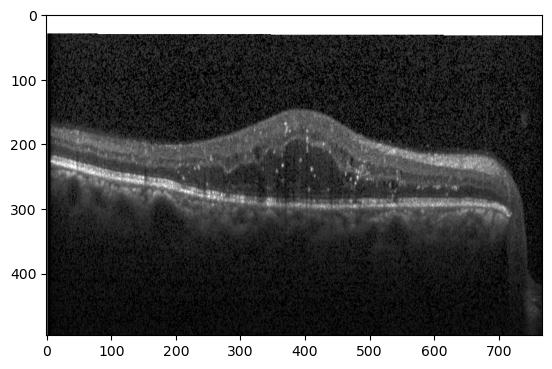

In [65]:
plt.imshow(X_tt[35],cmap='gray')

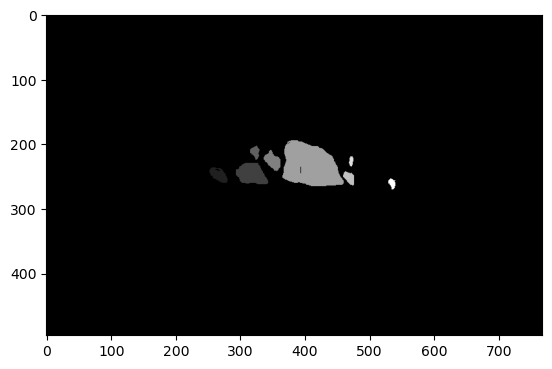

In [11]:
plt.imshow(y_tt[35],cmap='gray')

In [12]:
type(X_tt[35]), X_tt[35].shape

(numpy.ndarray, (496, 768))

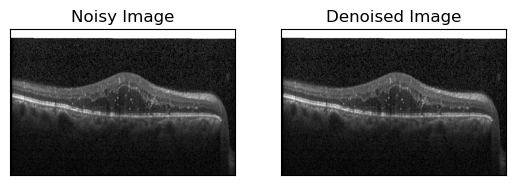

In [14]:
#FFT 

# Read the noisy image
noisy_img = cv2.cvtColor(X_tt[35], cv2.COLOR_RGB2BGR)
noisy_img = cv2.cvtColor(noisy_img, cv2.COLOR_BGR2GRAY)

# Perform FFT
f = np.fft.fft2(noisy_img)
f_shift = np.fft.fftshift(f)

# Apply Gaussian filter to remove high-frequency noise
#rows, cols = noisy_img.shape
#crow, ccol = rows // 2, cols // 2
#f_shift[crow - 30:crow + 30, ccol - 30:ccol + 30] = 0

# Perform inverse FFT
f_ishift = np.fft.ifftshift(f_shift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)

# Display original and denoised images
plt.subplot(121), plt.imshow(noisy_img, cmap='gray')
plt.title('Noisy Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img_back, cmap='gray')
plt.title('Denoised Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
#Increasing contrast using histogram equalization

# Read the image
image = cv2.cvtColor(X_tt[35], cv2.COLOR_RGB2BGR)

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply histogram equalization
equalized_image = cv2.equalizeHist(gray_image)

# Convert the equalized image back to BGR format
equalized_image_bgr = cv2.cvtColor(equalized_image, cv2.COLOR_GRAY2BGR)

# Display the original and equalized images
cv2.imshow('Original Image', image)
cv2.imshow('Equalized Image', equalized_image_bgr)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
# Read the noisy image
noisy_image = cv2.cvtColor(X_tt[35], cv2.COLOR_RGB2BGR)
noisy_image = cv2.cvtColor(noisy_image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to remove noise
denoised_image = cv2.GaussianBlur(noisy_image, (5, 5), 0)  # Adjust the kernel size as needed

# Display the original and denoised images
cv2.imshow('Noisy Image', noisy_image)
cv2.imshow('Denoised Image', denoised_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [24]:
paths = ['oct-segmentation/2015_BOE_Chiu/Subject_0{}.mat'.format(i) for i in range(1,10)]+['oct-segmentation/2015_BOE_Chiu/Subject_10.mat']

In [44]:
def thresh(x):
    if x>0.5:
        return 1
    else:
        return 0

thresh = np.vectorize(thresh, otypes=[np.float32]) #apply thresh function pixel-wise to the img inp

In [50]:
def visualize(paths):
    new_X, new_Y= [],[]
    for path in paths:
        mat = scipy.io.loadmat(path)
        
        X = np.transpose(mat['images'],(2,0,1))
        Y = np.transpose(mat['manualFluid1'],(2,0,1))
        
        new_X.append(X[:11])
        new_X.append(X[11:22])
        new_X.append(X[22:33])
        new_X.append(X[33:44])
        new_X.append(X[44:55])
        new_X.append(X[55:62])
        
        new_Y.append(Y[:11])
        new_Y.append(Y[11:22])
        new_Y.append(Y[22:33])
        new_Y.append(Y[33:44])
        new_Y.append(Y[44:55])
        new_Y.append(Y[55:61])
        #Y = thresh(Y)
        #print(Y)
        
        print(X.shape,Y.shape)
        
        # prediction visualization
        for i in range(len(new_X)):
            print(i)
            nrows = 11
            fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(15, 10))
            for j in range(nrows):
                axes[j][0].imshow(np.reshape(new_X[i][j], (496, 768)))
                axes[j][1].imshow(np.reshape(new_Y[i][j], (496, 768)))
            plt.show()

(61, 496, 768) (61, 496, 768)
0


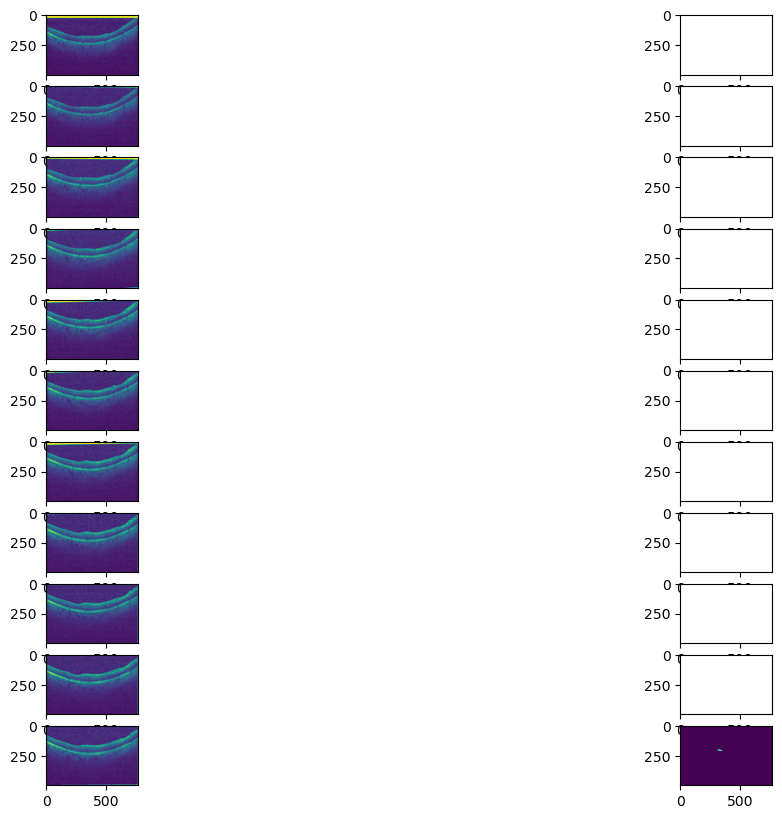

1


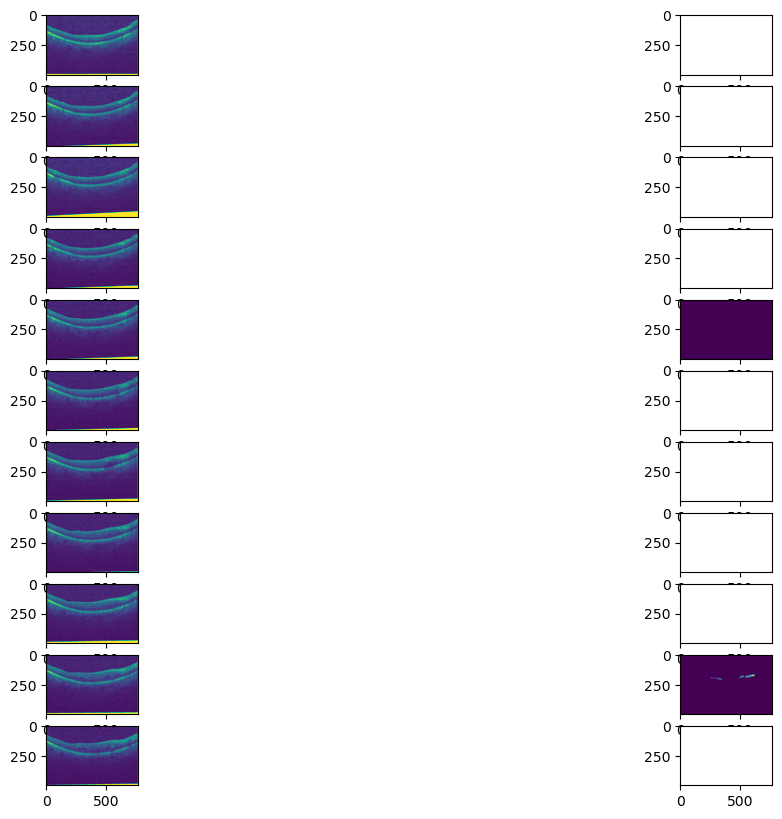

2


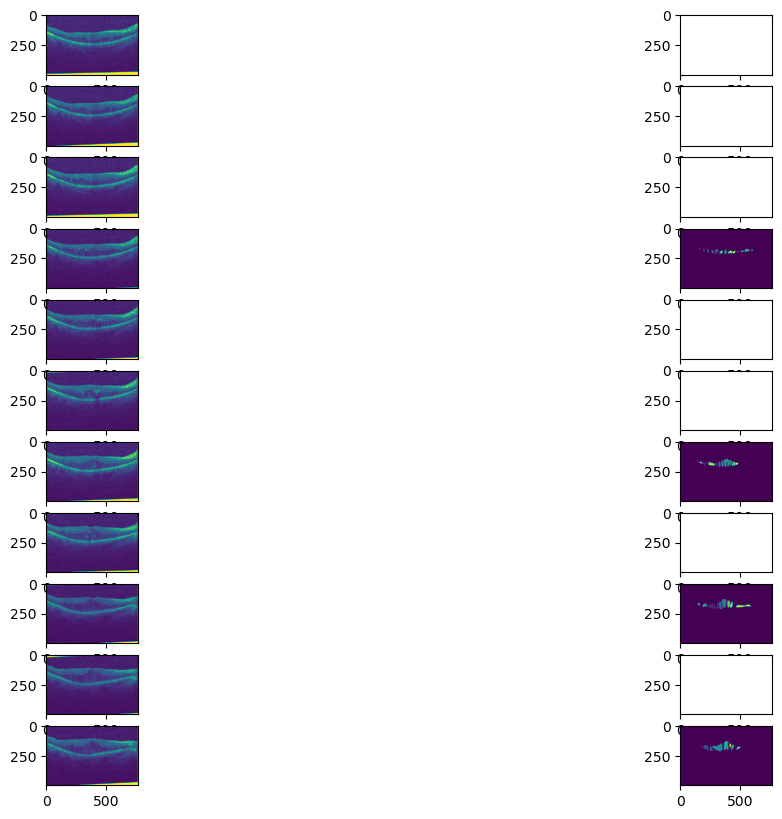

3


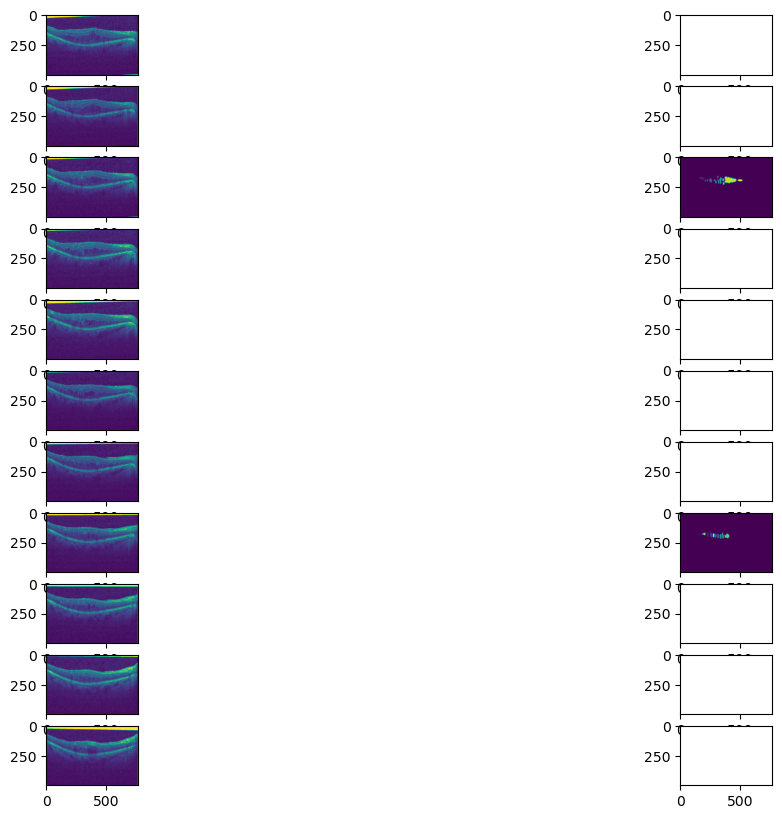

4


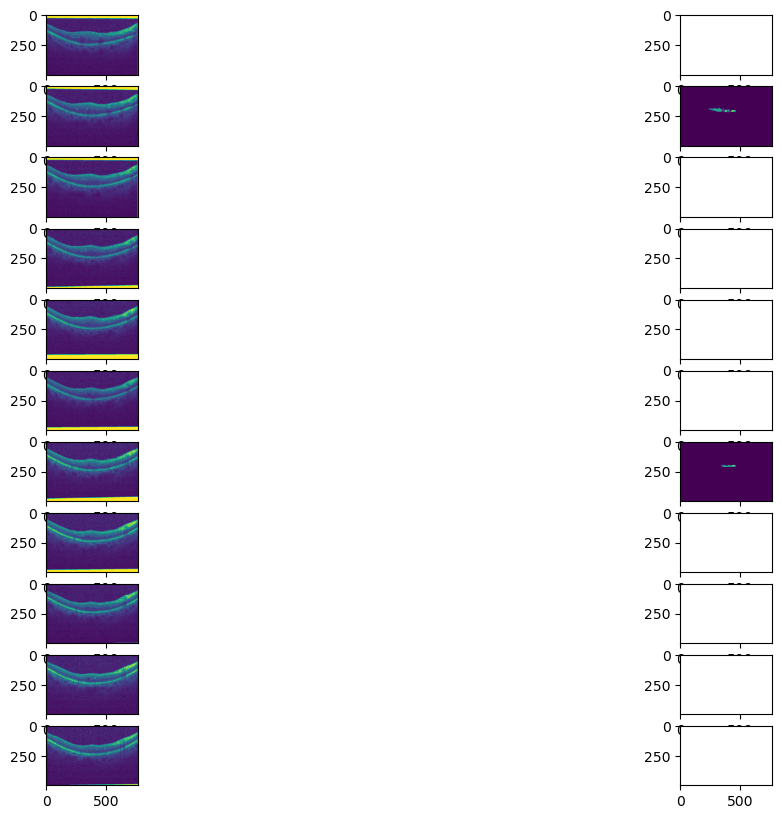

5


IndexError: index 6 is out of bounds for axis 0 with size 6

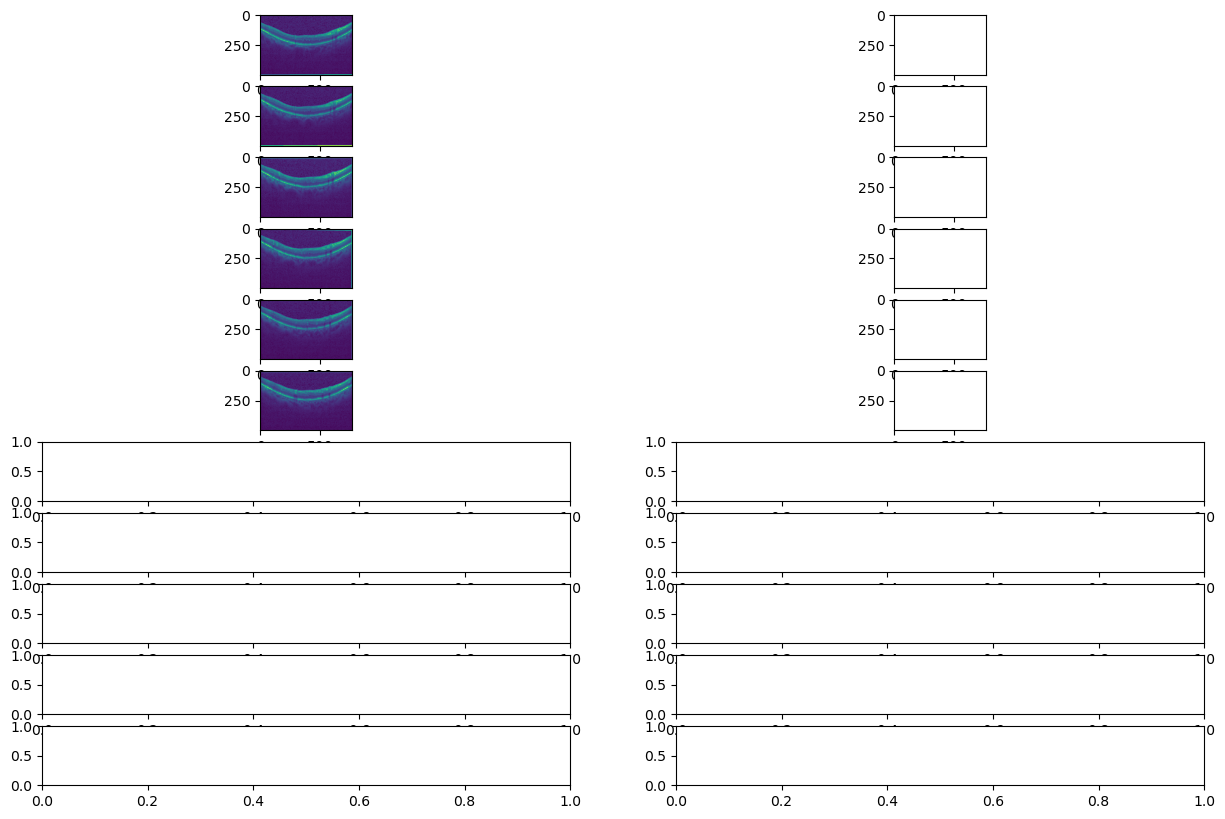

In [51]:
visualize(paths[5:6])

In [45]:
X, y = [],[]

In [80]:
def preprocess(path,data_indexes):
    x, y, new_imgs = [],[], []
    
    mat = scipy.io.loadmat(path)
      
    imgs = np.transpose(mat['images'],(2,0,1))
    plt.subplot(121), plt.imshow(imgs[35])
    for i in range(imgs.shape[0]):
        img = filter_image(imgs[i])
        img = img/255
        new_imgs.append(img)
    new_imgs = np.array(new_imgs)
    print(new_imgs.shape[0])
    imgs = resize(new_imgs,(new_imgs.shape[0],224,224))
    plt.subplot(122), plt.imshow(imgs[35])
        
    fluids = np.transpose(mat['manualFluid1'],(2,0,1))
    fluids = thresh(fluids)
    #plt.subplot(123), plt.imshow(fluids[35],cmap='gray')
    fluids = resize(fluids, (fluids.shape[0],224,224))
        
    for i in data_indexes:
        x += [np.expand_dims(imgs[i],axis=2)]
        y += [np.expand_dims(fluids[i],axis=2)]
    
    return np.array(x), np.array(y)

61


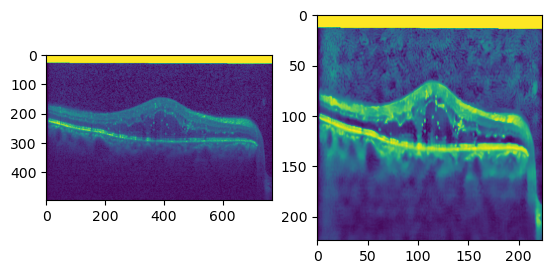

In [81]:
x_ttt, y_ttt = preprocess(paths[0],[10,15,20,25,28,30,32,35,40,45,50])

61
11


AttributeError: 'numpy.ndarray' object has no attribute 'append'

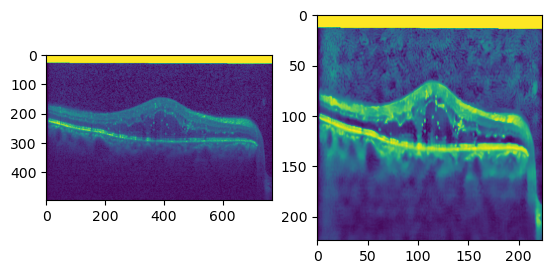

In [82]:
for i in range(len(paths)):
    data_indexes = [[10,15,20,25,28,30,32,35,40,45,50],
                    [10,15,20,25,28,30,32,35,40,45,50],
                    [10,15,20,25,28,30,32,35,40,45,50],
                    [6,11,16,21,24,26,28,31,36,41,46],
                    [8,13,18,23,26,28,30,33,38,43,48],
                    [10,15,20,25,28,30,32,35,40,45,50],
                    [11,16,21,26,29,31,33,36,41,46,51],
                    [8,13,18,23,26,28,30,33,38,43,48],
                    [10,15,20,25,28,30,32,35,40,45,50],
                    [10,15,20,25,28,30,32,35,40,45,50]]
    X_t,y_t = preprocess(paths[i],data_indexes[i])
    print(len(X_t))
    for i in range(len(X_t)):
        X.append(X_t[i])
        y.append(y_t[i])

In [ ]:
X = np.array(X)
y = np.array(y)

In [ ]:
X.shape, y.shape

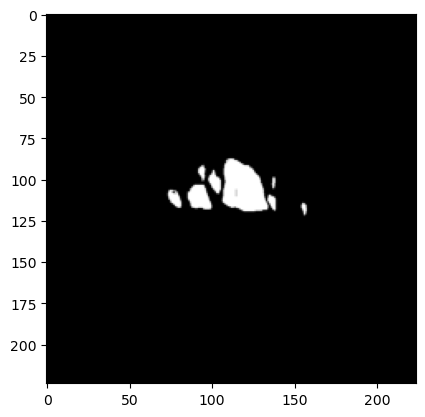

In [51]:
plt.imshow(y[7],cmap='gray')

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state = 0)

In [53]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((99, 224, 224, 1), (11, 224, 224, 1), (99, 224, 224, 1), (11, 224, 224, 1))

In [43]:
set(y_test.flatten())

{0.0,
 3.7289846e-07,
 5.515554e-05,
 0.0001148132,
 2.4303647e-05,
 0.06822061,
 0.14200978,
 0.0004612294,
 2.656842e-07,
 0.00032408928,
 0.0005835417,
 0.17857058,
 0.3992603,
 0.0023722572,
 0.0012066253,
 0.051931042,
 0.013677824,
 0.022886623,
 0.48399258,
 0.013576377,
 0.022659648,
 0.9988757,
 0.9999364,
 0.06921945,
 0.43060994,
 0.0009611975,
 0.00026691885,
 0.0008131656,
 0.00927325,
 0.04792847,
 0.0039152987,
 0.70644677,
 0.8960525,
 0.31301415,
 0.968055,
 0.027498666,
 0.061384123,
 0.009243991,
 0.9751372,
 0.9999269,
 0.8891902,
 0.9942342,
 0.4396726,
 0.81424916,
 0.87085927,
 0.45673573,
 0.4997388,
 0.27882588,
 0.9185811,
 0.6551,
 0.86594,
 6.881562e-05,
 0.64923674,
 0.8870297,
 0.29448146,
 0.0004076408,
 0.00025940777,
 0.0027062944,
 0.11399307,
 0.808932,
 0.39169568,
 0.00022204452,
 0.41318622,
 0.37512317,
 0.0051423814,
 0.023842981,
 0.9986755,
 0.00804792,
 0.09719262,
 0.031271193,
 0.009279642,
 0.36494166,
 0.26621383,
 0.8675017,
 0.6525569,
 

In [32]:
img = cv2.imread('request_form_github/y/108 OD - Copy.jpeg')

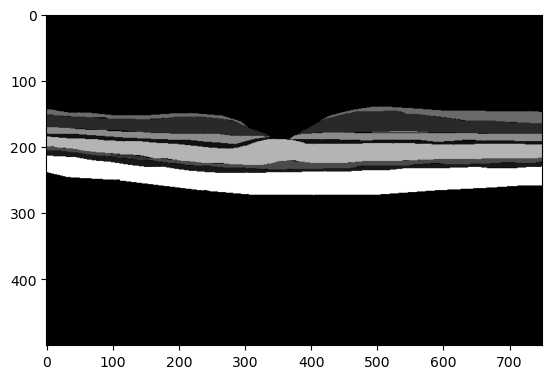

In [33]:
plt.imshow(img)

In [53]:
X = ['request_form_github/X/{} OD - Copy.jpeg'.format(i) for i in ['108','22','26','31','33','50','64']] + ['request_form_github/X/{} OS - Copy.jpeg'.format(i) for i in ['06','34','56']]
y = ['request_form_github/Y/{} OD - Copy.jpeg'.format(i) for i in ['108','22','26','31','33','50','64']] + ['request_form_github/Y/{} OS - Copy.jpeg'.format(i) for i in ['06','34','56']]

In [56]:
train_images = []
for path in X:
    print(path)
    img = cv2.imread(path,0)
    img = cv2.resize(img,(224,224))
    train_images.append(img)
    
train_images = np.array(train_images)

request_form_github/X/108 OD - Copy.jpeg
request_form_github/X/22 OD - Copy.jpeg
request_form_github/X/26 OD - Copy.jpeg
request_form_github/X/31 OD - Copy.jpeg
request_form_github/X/33 OD - Copy.jpeg
request_form_github/X/50 OD - Copy.jpeg
request_form_github/X/64 OD - Copy.jpeg
request_form_github/X/06 OS - Copy.jpeg
request_form_github/X/34 OS - Copy.jpeg
request_form_github/X/56 OS - Copy.jpeg


In [57]:
train_images.shape

(10, 224, 224)

In [65]:
train_masks = []
for path in y:
    mask = cv2.imread(path,0)
    mask = cv2.resize(mask,(224,224),interpolation = cv2.INTER_NEAREST)
    train_masks.append(mask)

train_masks= np.array(train_masks)

In [66]:
train_masks.shape

(10, 224, 224)

In [67]:
np.unique(train_masks)

array([  0,  16,  24,  41,  74, 106, 139, 180, 255], dtype=uint8)

In [54]:
# U-Net
inp = Input(shape=(224,224,1))

#Contraction path
c1 = Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(inp)
c1 = Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(c1)
p1 = MaxPool2D((2,2))(c1)

c2 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal',padding='same')(p1)
c2 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal',padding='same')(c2)
p2 = MaxPool2D((2,2))(c2)

c3 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal',padding='same')(p2)
c3 = Conv2D(256, (3,3), activation='relu',kernel_initializer='he_normal',padding='same')(c3)
p3 = MaxPool2D((2,2))(c3)

c4 = Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal',padding='same')(p3)
c4 = Conv2D(512, (3,3), activation='relu',kernel_initializer='he_normal',padding='same')(c4)

#Bottleneck layer
p4 = MaxPool2D((2,2))(c4)
c5 = Conv2D(1024, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(p4)
u6 = Conv2DTranspose(512, (2,2), strides=(2,2), activation='relu', padding='same', kernel_initializer='he_normal')(c5)

#Expansive path
u6 = Concatenate()([u6,c4])
c6 = Conv2D(512, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(u6)
c6 = Conv2D(512, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c6)

u7 = Conv2DTranspose(256, (2,2), strides=(2,2), activation='relu', padding='same', kernel_initializer='he_normal')(c6)
u7 = Concatenate()([u7,c3])
c7 = Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(u7)
c7 = Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c7)

u8 = Conv2DTranspose(128, (2,2), strides=(2,2), activation='relu', padding='same', kernel_initializer='he_normal')(c7)
u8 = Concatenate()([u8,c2])
c8 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(u8)
c8 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c8)

u9 = Conv2DTranspose(64, (2,2), strides=(2,2), activation='relu', padding='same', kernel_initializer='he_normal')(c8)
u9 = Concatenate()([u9,c1])
c9 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(u9)
c9 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c9)

op = Conv2D(1,(1,1),activation='sigmoid')(c9)

model = Model(inp, op)
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 64)         640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 224, 224, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [56]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto', restore_best_weights=True)
results = model.fit(X_train, y_train, batch_size=19, epochs=100, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/60
6/6 [==============================] - 73s 12s/step - loss: 0.4479 - accuracy: 0.9859
Epoch 2/60
6/6 [==============================] - 73s 12s/step - loss: 0.2659 - accuracy: 0.9859
Epoch 3/60
6/6 [==============================] - 75s 12s/step - loss: 0.1183 - accuracy: 0.9859
Epoch 4/60
6/6 [==============================] - 72s 11s/step - loss: 0.1240 - accuracy: 0.9859
Epoch 5/60
6/6 [==============================] - 71s 11s/step - loss: 0.1071 - accuracy: 0.9859
Epoch 6/60
6/6 [==============================] - 72s 12s/step - loss: 0.0983 - accuracy: 0.9859
Epoch 7/60
6/6 [==============================] - 74s 12s/step - loss: 0.0899 - accuracy: 0.9859
Epoch 8/60
6/6 [==============================] - 72s 12s/step - loss: 0.0749 - accuracy: 0.9859
Epoch 9/60
6/6 [==============================] - 74s 12s/step - loss: 0.0550 - accuracy: 0.9859
Epoch 10/60
6/6 [==============================] - 72s 12s/step - loss: 0.0458 - accuracy: 0.9859
Epoch 11/60
6/6 [============

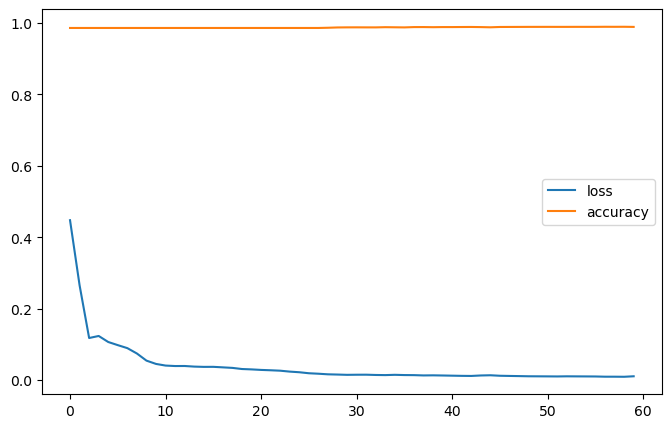

In [57]:
pd.DataFrame(results.history).plot(figsize=(8,5))
plt.show()

In [58]:
model.evaluate(X_test,y_test)

1/1 [==============================] - 3s 3s/step - loss: 0.0186 - accuracy: 0.9868


[0.01859297975897789, 0.9867919683456421]

In [59]:
pred = model.predict(X_test)

1/1 [==============================] - 3s 3s/step


In [60]:
pred.shape, y_test.shape

((11, 224, 224, 1), (11, 224, 224, 1))

In [61]:
import tensorflow.keras.backend as K

In [62]:
def dice_coef(y_true, y_pred, smooth=100):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

In [63]:
def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [64]:
print(dice_coef_loss(y_test,pred))

tf.Tensor(0.69391286, shape=(), dtype=float32)


In [71]:
print(dice_coef(y_test,pred))

tf.Tensor(0.30608717, shape=(), dtype=float32)


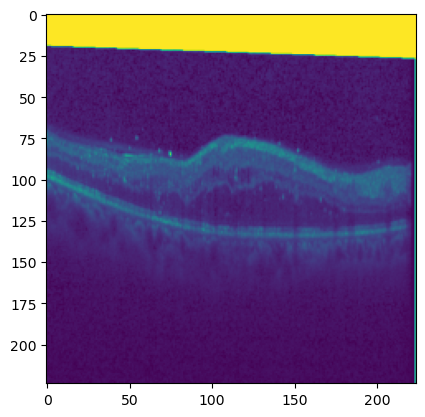

In [66]:
plt.imshow(X_test[3])

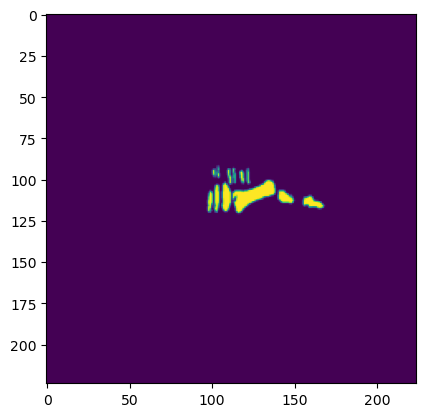

In [67]:
plt.imshow(y_test[3])

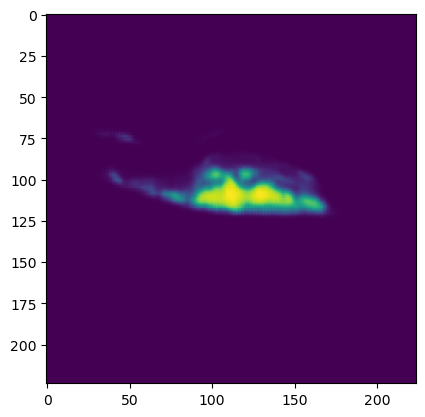

In [68]:
plt.imshow(pred[3])

In [69]:
new_pred, new_Xtest, new_ytest = [], [], []

new_pred.append(pred[:4])
new_pred.append(pred[4:8])
new_pred.append(pred[8:])

new_Xtest.append(X_test[:4])
new_Xtest.append(X_test[4:8])
new_Xtest.append(X_test[8:])

new_ytest.append(y_test[:4])
new_ytest.append(y_test[4:8])
new_ytest.append(y_test[8:])

IndexError: index 3 is out of bounds for axis 0 with size 3

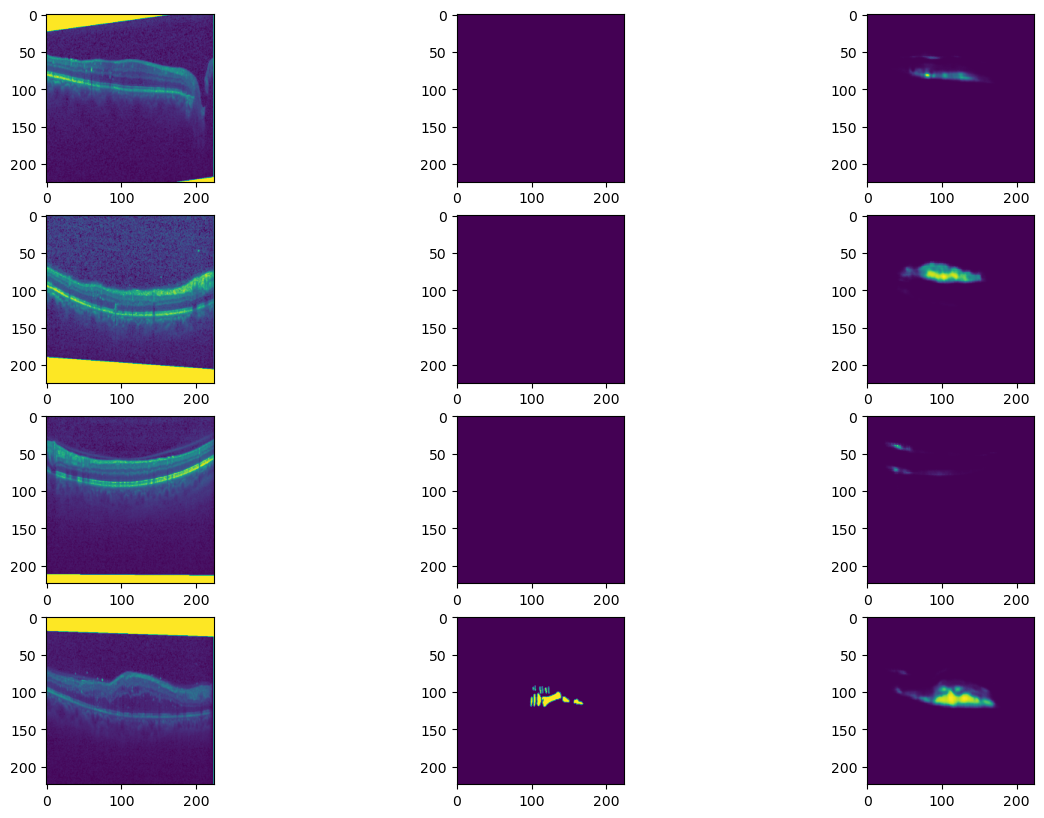

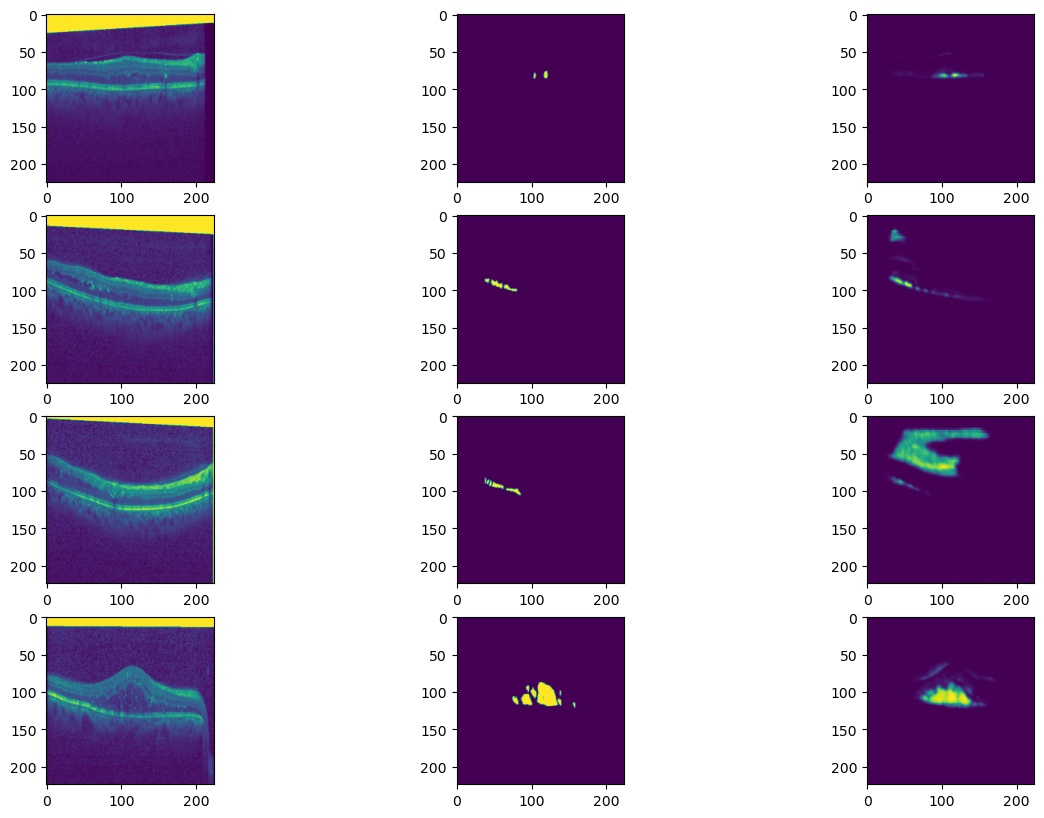

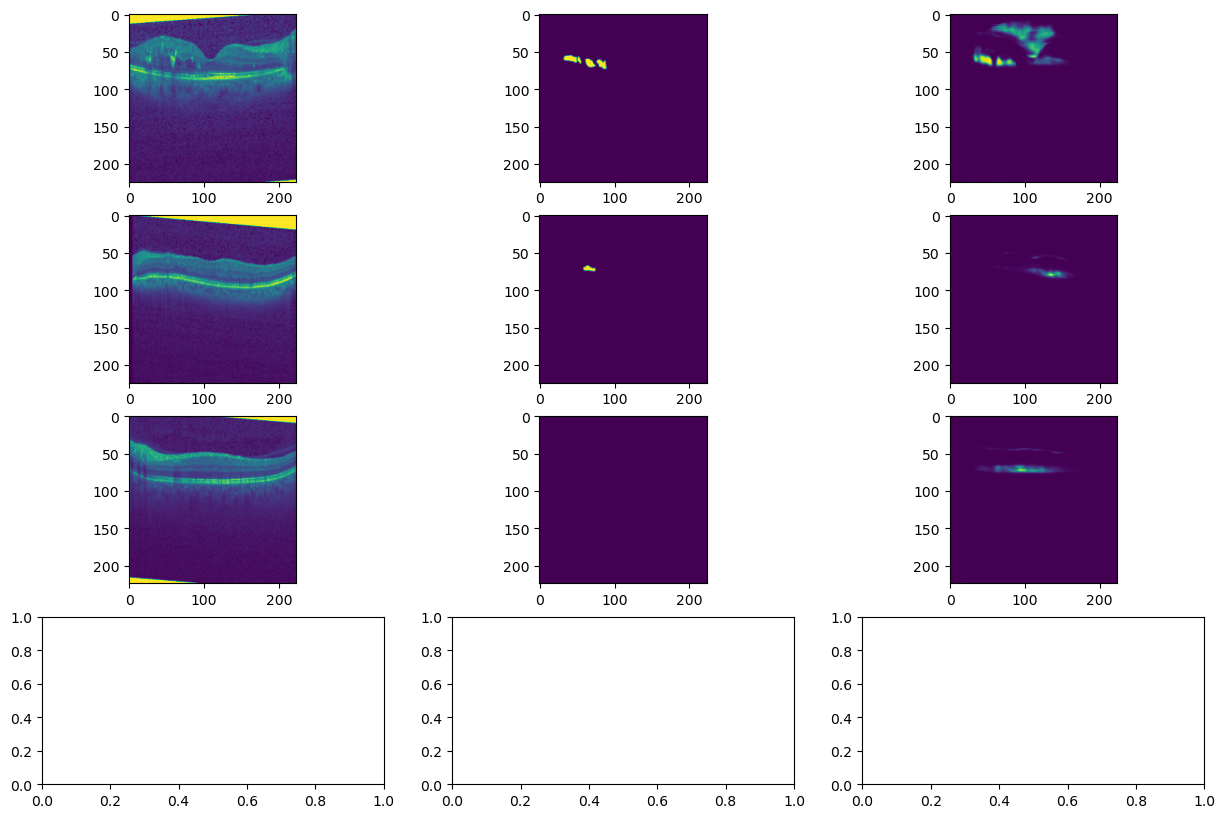

In [70]:
# prediction visualization
for i in range(len(new_Xtest)):
    nrows = 4
    fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(15, 10))
    for j in range(nrows):
        axes[j][0].imshow(np.reshape(new_Xtest[i][j], (224, 224)))
        axes[j][1].imshow(np.reshape(new_ytest[i][j], (224, 224)))
        axes[j][2].imshow(np.reshape(new_pred[i][j], (224, 224)))

plt.show()

# Filter - Test

In [15]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

img = cv2.imread('sample_image.png',0)



In [16]:
def gaussian_filter(std, kernel_size=3, mean=0):
    """
    Creates a Gaussian filter.
    
    Parameters
    ----------
    std : float
        The standard deviation of the Gaussian filter.
    kernel_size : int, optional
        The size of the kernel. The default is 3.
    mean : int, optional
        The mean of the Gaussian filter. The default is 0.
    
    Returns
    -------
    numpy.ndarray
        The Gaussian filter.
    
    """
    ## Creating the kernel
    kernel = np.zeros(shape=(kernel_size,kernel_size))
    ind = list(range((kernel_size-1)//-2 - mean,(kernel_size-1)//2 + 1 - mean))  # Center index is 0
        
    ## Iterating over the kernel
    for i in range(kernel_size):
        for j in range(kernel_size):
            
            kernel[i,j] = np.exp(-1*(ind[i]**2+ind[j]**2)/(2*std**2))
    
    return kernel * (1/(2*np.pi*std**2))

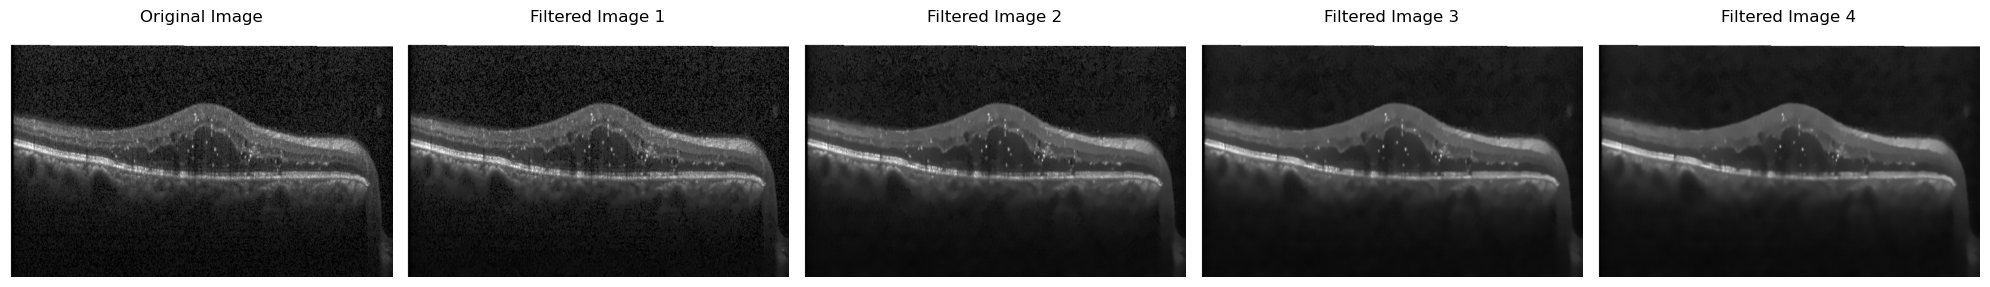

In [17]:
# Apply multiple fastNL filters
filtered_images = []
for i in [5,10,15,20]:
    filtered_img = cv2.fastNlMeansDenoising(img, h=i, templateWindowSize=7, searchWindowSize=21)
    filtered_images.append(filtered_img)

# Plot the results
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

for i in range(4):
    axes[i+1].imshow(filtered_images[i], cmap='gray')
    axes[i+1].set_title(f'Filtered Image {i+1}')
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()



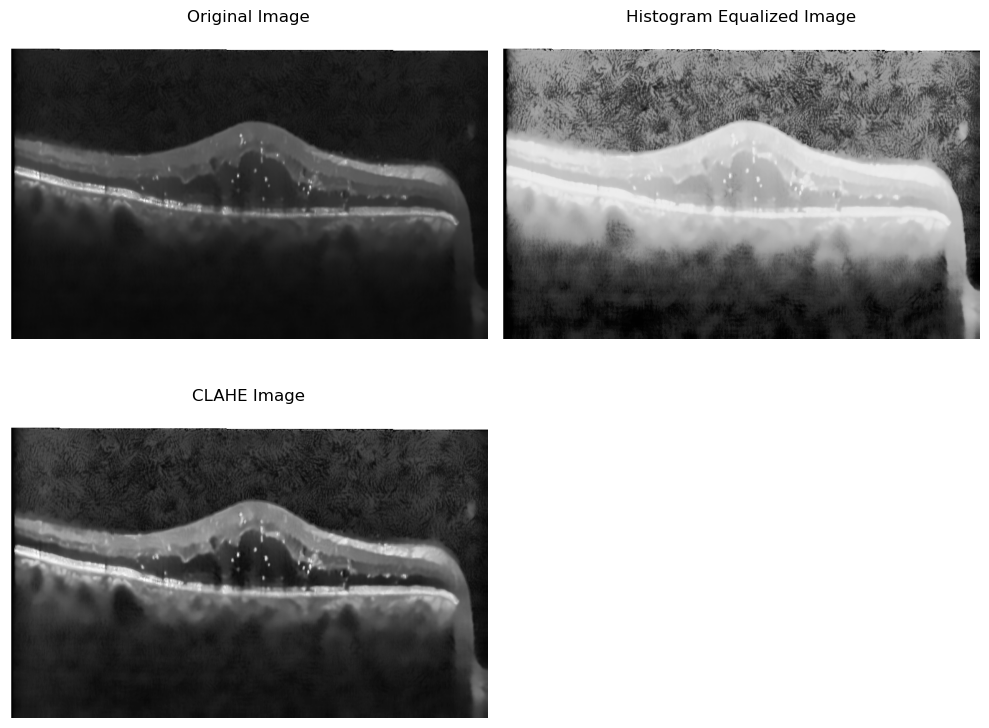

In [18]:
filtered_img = cv2.fastNlMeansDenoising(img, h=15, templateWindowSize=7, searchWindowSize=21)

equalized_image = cv2.equalizeHist(filtered_img)

# Apply CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
clahe_image = clahe.apply(filtered_img)

# Plotting
plt.figure(figsize=(10, 8))

# Original Image
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(filtered_img, cv2.COLOR_GRAY2RGB))
plt.title('Original Image')
plt.axis('off')

# Histogram Equalized Image
plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(equalized_image, cv2.COLOR_GRAY2RGB))
plt.title('Histogram Equalized Image')
plt.axis('off')

# CLAHE Image
plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(clahe_image, cv2.COLOR_GRAY2RGB))
plt.title('CLAHE Image')
plt.axis('off')

plt.tight_layout()
plt.show()

In [19]:
img = cv2.imread('sample_image.png',0)

def apply_clahe(clip_limit, grid_size, filter_h, filter_window, search_window):
    filtered_img = cv2.fastNlMeansDenoising(img, h=filter_h, templateWindowSize=filter_window, searchWindowSize=search_window)
    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(grid_size, grid_size))
    clahe_image = clahe.apply(filtered_img)
    
    
    # Plot both original and CLAHE images
    plt.figure(figsize=(12, 6))
    
    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(img,cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    # CLAHE Image
    plt.subplot(1, 2, 2)
    plt.imshow(clahe_image,cmap='gray')
    plt.title('CLAHE Image')
    plt.axis('off')
    
    plt.show()


# Define the range for parameters
clip_limit_slider = IntSlider(min=1, max=10, step=1, value=7, description='Clip Limit')
grid_size_slider = IntSlider(min=4, max=16, step=1, value=12, description='Grid Size')
filter_h = IntSlider(min=4, max=30, step=1, value=15, description='H')
filter_window = IntSlider(min=4, max=20, step=1, value=7, description='templateWindowSize')
search_window = IntSlider(min=4, max=50, step=1, value=21, description='searchWindowSize')


# Create the interactive widget
interact(apply_clahe, clip_limit=clip_limit_slider, grid_size=grid_size_slider, filter_h=filter_h, filter_window=filter_window,search_window=search_window)

interactive(children=(IntSlider(value=7, description='Clip Limit', max=10, min=1), IntSlider(value=12, descrip…

<function __main__.apply_clahe(clip_limit, grid_size, filter_h, filter_window, search_window)>

In [20]:
def filter_image(img,clip_limit=7, grid_size=12, filter_h=15, filter_window=7, search_window=25):
    filtered_img = cv2.fastNlMeansDenoising(img, h=filter_h, templateWindowSize=filter_window, searchWindowSize=search_window)
    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(grid_size, grid_size))
    clahe_image = clahe.apply(filtered_img)
    
    return clahe_image

In [21]:
filter_image(img)

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255,   8, ...,  60,  60,  60],
       [255, 255,   8, ...,  60,  60,  60],
       [255, 255,   8, ...,  60,  60,  60]], dtype=uint8)